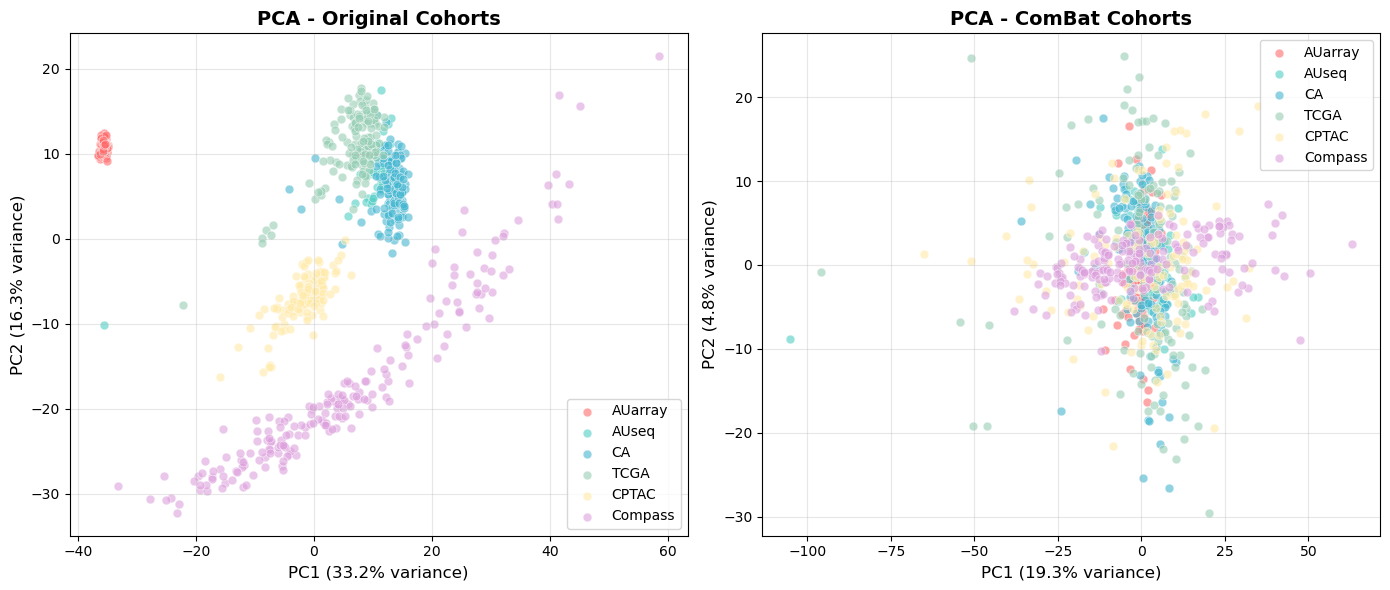

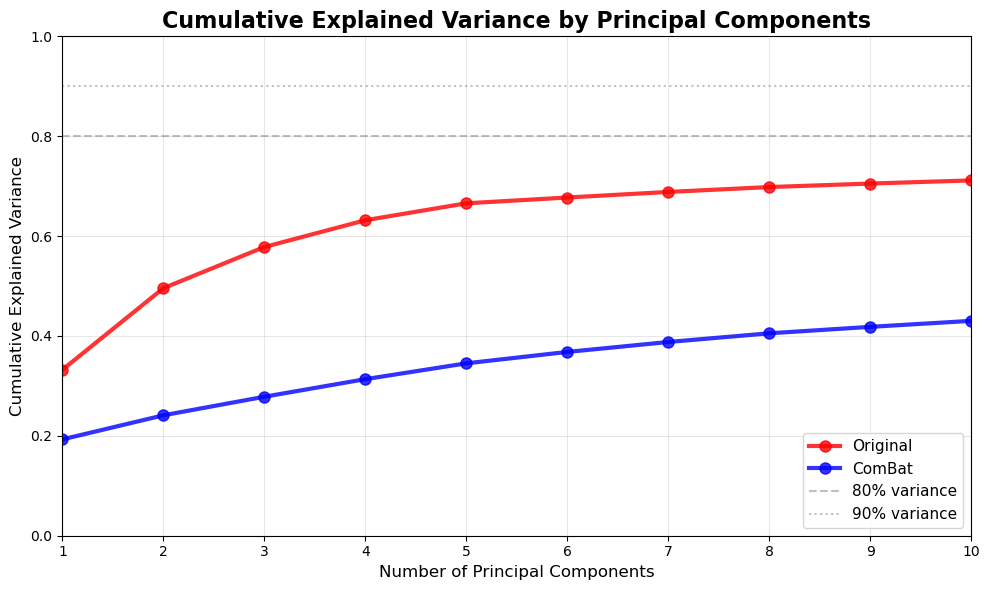

In [1]:
#Comparación cohortes tras normalización por Combat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# 1. CARGAR COHORTES NO NORMALIZADAS (ORIGINALES)
cohorts_original = {}
cohorts_original['AUarray'] = pd.read_csv("../Cohortes/Log2TPM_plus1_Data/AUarrayClinicaExp_Log2TPMplus1.csv")
cohorts_original['AUseq'] = pd.read_csv("../Cohortes/Log2TPM_plus1_Data/AUseqClinicaExp_Log2TPMplus1.csv")
cohorts_original['CA'] = pd.read_csv("../Cohortes/Log2TPM_plus1_Data/CAClinicaExp_Log2TPMplus1.csv")
cohorts_original['TCGA'] = pd.read_csv("../Cohortes/Log2TPM_plus1_Data/TCGAClinicaExp_Log2TPMplus1.csv")
cohorts_original['CPTAC'] = pd.read_feather("../Cohortes/Log2TPM_plus1_Data/CPTAC_Log2TPMplus1_andClinicalInfo.feather")
cohorts_original['Compass'] = pd.read_csv("../Cohortes/Log2TPM_plus1_Data/Compass_Log2TPMsplus1_Counts_and_Clinical.csv")

# 2. CARGAR COHORTES NORMALIZADAS (COMBAT)
cohorts_combat = {}
cohorts_combat['AUarray'] = pd.read_feather("../Cohortes/Combat_Data/COMBAT_with6datasets/Combat6_Final_AUarray_Log2TPMplus1.feather")
cohorts_combat['AUseq'] = pd.read_feather("../Cohortes/Combat_Data/COMBAT_with6datasets/Combat6_Final_AUseq_Log2TPMplus1.feather")
cohorts_combat['CA'] = pd.read_feather("../Cohortes/Combat_Data/COMBAT_with6datasets/Combat6_Final_CA_Log2TPMplus1.feather")
cohorts_combat['TCGA'] = pd.read_feather("../Cohortes/Combat_Data/COMBAT_with6datasets/Combat6_Final_TCGA_Log2TPMplus1.feather")
cohorts_combat['CPTAC'] = pd.read_feather("../Cohortes/Combat_Data/COMBAT_with6datasets/Combat6_Final_CPTAC_Log2TPMplus1.feather")
cohorts_combat['Compass'] = pd.read_feather("../Cohortes/Combat_Data/COMBAT_with6datasets/Combat6_Final_Compass_Log2TPMplus1.feather")

# 3. COLUMNAS CLÍNICAS A EXCLUIR
clin_cols = ['ID_Paciente', 'Tiempo', 'Supervivencia', 'Edad', 'Sexo', 'Grado agrupado', 
             'Estadío agrupado', 'Subtipo molecular', 'Dataset', 'vital_status', 'sex', 
             'age', 'follow_up_days', 'Alive', 'First.Tx', 'Age.at.enrolment', 'Gender', 
             'Stage', 'Survival.days', 'Unnamed: 0', 'index']

# 4. FUNCIÓN PARA PREPARAR DATOS COMBINADOS
def prepare_combined_data(cohorts_dict):
    all_gene_sets = []
    for name, df in cohorts_dict.items():
        gene_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                     if col not in clin_cols and not col.startswith('Unnamed')]
        all_gene_sets.append(set(gene_cols))
    
    common_genes = list(set.intersection(*all_gene_sets))
    if len(common_genes) > 1000:
        common_genes = common_genes[:1000]
    
    combined_data = []
    cohort_labels = []
    for name, df in cohorts_dict.items():
        gene_data = df[common_genes].fillna(df[common_genes].median())
        combined_data.append(gene_data.values)
        cohort_labels.extend([name] * len(df))
    
    return np.vstack(combined_data), cohort_labels

# 5. PREPARAR DATOS PARA PCA
data_original, labels_original = prepare_combined_data(cohorts_original)
data_combat, labels_combat = prepare_combined_data(cohorts_combat)

# 6. FIGURA 1: PCA COMPARATIVO
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD']
cohort_names = ['AUarray', 'AUseq', 'CA', 'TCGA', 'CPTAC', 'Compass']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# PCA ORIGINAL
pca_orig = PCA(n_components=2, random_state=42)
scaled_orig = StandardScaler().fit_transform(data_original)
pca_orig_result = pca_orig.fit_transform(scaled_orig)

for i, cohort in enumerate(cohort_names):
    mask = np.array(labels_original) == cohort
    if np.any(mask):
        ax1.scatter(pca_orig_result[mask, 0], pca_orig_result[mask, 1], 
                   c=colors[i], alpha=0.6, s=40, label=cohort, edgecolors='white', linewidth=0.5)

ax1.set_title('PCA - Original Cohorts', fontsize=14, fontweight='bold')
ax1.set_xlabel(f'PC1 ({pca_orig.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax1.set_ylabel(f'PC2 ({pca_orig.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# PCA COMBAT
pca_combat = PCA(n_components=2, random_state=42)
scaled_combat = StandardScaler().fit_transform(data_combat)
pca_combat_result = pca_combat.fit_transform(scaled_combat)

for i, cohort in enumerate(cohort_names):
    mask = np.array(labels_combat) == cohort
    if np.any(mask):
        ax2.scatter(pca_combat_result[mask, 0], pca_combat_result[mask, 1], 
                   c=colors[i], alpha=0.6, s=40, label=cohort, edgecolors='white', linewidth=0.5)

ax2.set_title('PCA - ComBat Cohorts', fontsize=14, fontweight='bold')
ax2.set_xlabel(f'PC1 ({pca_combat.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax2.set_ylabel(f'PC2 ({pca_combat.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7. FIGURA 2: VARIANZA EXPLICADA ACUMULADA
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

components_range = range(1, 11)
pca_full_orig = PCA(n_components=10, random_state=42)
pca_full_combat = PCA(n_components=10, random_state=42)

pca_full_orig.fit(scaled_orig)
pca_full_combat.fit(scaled_combat)

ax.plot(components_range, np.cumsum(pca_full_orig.explained_variance_ratio_), 
        'o-', color='red', linewidth=3, markersize=8, label='Original', alpha=0.8)
ax.plot(components_range, np.cumsum(pca_full_combat.explained_variance_ratio_), 
        'o-', color='blue', linewidth=3, markersize=8, label='ComBat', alpha=0.8)

ax.axhline(y=0.8, color='gray', linestyle='--', alpha=0.5, label='80% variance')
ax.axhline(y=0.9, color='gray', linestyle=':', alpha=0.5, label='90% variance')

ax.set_title('Cumulative Explained Variance by Principal Components', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of Principal Components', fontsize=12)
ax.set_ylabel('Cumulative Explained Variance', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1)
ax.set_xlim(1, 10)

plt.tight_layout()
plt.show()

🔍 Detecting outliers in each cohort using pyOD...
   Processing AUarray (125 samples, 14826 genes)...
   Processing AUarray (125 samples, 14826 genes)...
   AUarray: 7/125 outliers detected (5.6%)
   AUarray: 7/125 outliers detected (5.6%)
   Processing AUseq (59 samples, 14826 genes)...
   Processing AUseq (59 samples, 14826 genes)...
   AUseq: 3/59 outliers detected (5.1%)
   AUseq: 3/59 outliers detected (5.1%)
   Processing CA (163 samples, 14826 genes)...
   Processing CA (163 samples, 14826 genes)...
   CA: 9/163 outliers detected (5.5%)
   CA: 9/163 outliers detected (5.5%)
   Processing TCGA (141 samples, 14826 genes)...
   Processing TCGA (141 samples, 14826 genes)...
   TCGA: 7/141 outliers detected (5.0%)
   TCGA: 7/141 outliers detected (5.0%)
   Processing CPTAC (129 samples, 14833 genes)...
   Processing CPTAC (129 samples, 14833 genes)...
   CPTAC: 7/129 outliers detected (5.4%)
   CPTAC: 7/129 outliers detected (5.4%)
   Processing Compass (194 samples, 14826 genes)...


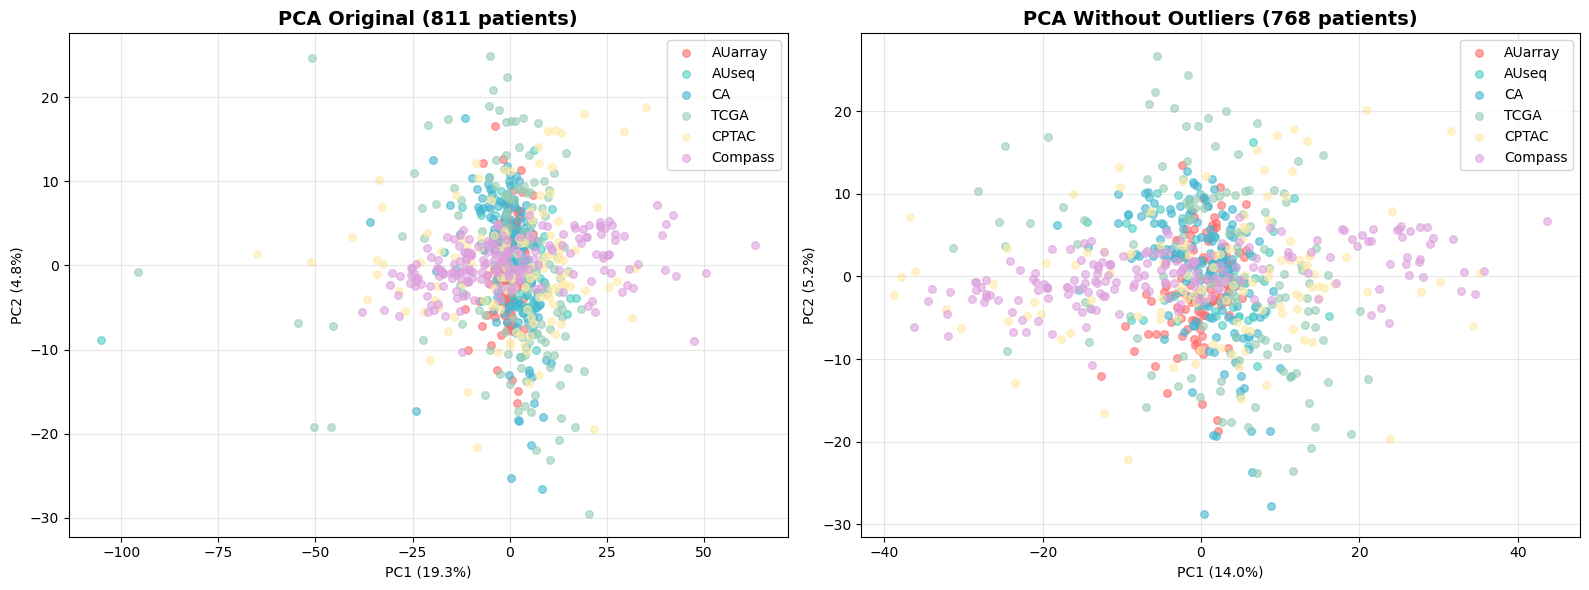

✅ OUTLIER ANALYSIS COMPLETED
📊 Cohorts processed: AUarray, AUseq, CA, TCGA, CPTAC, Compass
   AUarray: 125 → 118 patients (7 outliers removed)
      🔍 Outliers removed: DO32825, DO32831, DO33016, DO33488, DO34616, DO34961, DO49087
   AUseq: 59 → 56 patients (3 outliers removed)
      🔍 Outliers removed: DO33168, DO34336, DO49184
   CA: 163 → 154 patients (9 outliers removed)
      🔍 Outliers removed: DO224633, DO35098, DO35100, DO35160, DO35242, DO35406, DO35424, DO49418, DO51543
   TCGA: 141 → 134 patients (7 outliers removed)
      🔍 Outliers removed: TCGA.2J.AABV.01, TCGA.HV.A7OP.01, TCGA.HZ.8003.01, TCGA.IB.7897.01, TCGA.IB.8126.01, TCGA.IB.AAUM.01, TCGA.LB.A9Q5.01
   CPTAC: 129 → 122 patients (7 outliers removed)
      🔍 Outliers removed: C3L-02115, C3N-00517, C3N-01167, C3N-01715, C3N-03426, C3N-03430, C3N-04284
   Compass: 194 → 184 patients (10 outliers removed)
      🔍 Outliers removed: PCSI_0630, PCSI_0648, PCSI_0650, PCSI_0742, PCSI_1067, PCSI_1068, PCSI_1070, PCSI_1074, PCS

In [2]:
# ===== ANÁLISIS SIMPLIFICADO DE OUTLIERS =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pyod.models.iforest import IForest
import warnings
warnings.filterwarnings('ignore')

# Cargar cohortes
cohorts = {
    'AUarray': pd.read_feather("../Cohortes/Combat_Data/COMBAT_with6datasets/Combat6_Final_AUarray_Log2TPMplus1.feather"),
    'AUseq': pd.read_feather("../Cohortes/Combat_Data/COMBAT_with6datasets/Combat6_Final_AUseq_Log2TPMplus1.feather"),
    'CA': pd.read_feather("../Cohortes/Combat_Data/COMBAT_with6datasets/Combat6_Final_CA_Log2TPMplus1.feather"),
    'TCGA': pd.read_feather("../Cohortes/Combat_Data/COMBAT_with6datasets/Combat6_Final_TCGA_Log2TPMplus1.feather"),
    'CPTAC': pd.read_feather("../Cohortes/Combat_Data/COMBAT_with6datasets/Combat6_Final_CPTAC_Log2TPMplus1.feather"),
    'Compass': pd.read_feather("../Cohortes/Combat_Data/COMBAT_with6datasets/Combat6_Final_Compass_Log2TPMplus1.feather")
}

# Lista de columnas clínicas a excluir
clin_cols = ['ID_Paciente', 'Tiempo', 'Supervivencia', 'Edad', 'Sexo', 'Grado agrupado', 
             'Estadío agrupado', 'Subtipo molecular', 'Dataset', 'vital_status', 'sex', 
             'age', 'follow_up_days', 'Alive', 'First.Tx', 'Age.at.enrolment', 'Gender', 
             'Stage', 'Survival.days']

# 1. DETECCIÓN DE OUTLIERS CON PYOD
print("🔍 Detecting outliers in each cohort using pyOD...")
outlier_masks = {}
outlier_ids = {}  # Para almacenar los IDs de outliers
contamination = 0.05  # 5% de outliers

for name, df in cohorts.items():
    # Seleccionar solo genes
    gene_cols = [col for col in df.select_dtypes(include=[np.number]).columns if col not in clin_cols]
    gene_data = df[gene_cols].fillna(df[gene_cols].median())
    
    print(f"   Processing {name} ({len(df)} samples, {len(gene_cols)} genes)...")
    
    # Usar pyOD con Isolation Forest como en el ejemplo
    clf = IForest(contamination=contamination, random_state=42)
    
    # Escalar los datos
    scaled_data = StandardScaler().fit_transform(gene_data)
    
    # Entrenar el detector y obtener predicciones
    clf.fit(scaled_data)
    outliers = clf.labels_  # 0: inliers, 1: outliers
    outliers = outliers.astype(bool)  # Convertir a boolean
    
    outlier_masks[name] = outliers
    
    # Capturar IDs de outliers
    if 'ID_Paciente' in df.columns:
        outlier_patient_ids = df.loc[outliers, 'ID_Paciente'].tolist()
    else:
        # Si no hay columna ID_Paciente, usar el índice
        outlier_patient_ids = df.index[outliers].tolist()
    
    outlier_ids[name] = outlier_patient_ids
    n_outliers = sum(outliers)
    print(f"   {name}: {n_outliers}/{len(df)} outliers detected ({n_outliers/len(df)*100:.1f}%)")

# 2. GUARDAR COHORTES LIMPIAS INDIVIDUALES
df1_clean = cohorts['AUarray'][~outlier_masks['AUarray']].copy()
df2_clean = cohorts['AUseq'][~outlier_masks['AUseq']].copy()
df3_clean = cohorts['CA'][~outlier_masks['CA']].copy()
df4_clean = cohorts['TCGA'][~outlier_masks['TCGA']].copy()
df5_clean = cohorts['CPTAC'][~outlier_masks['CPTAC']].copy()
df5_compass_clean= cohorts['Compass'][~outlier_masks['Compass']].copy()

# ...existing code...

# 3. PCA CONJUNTO ANTES Y DESPUÉS
print("📊 Performing comparative PCA analysis...")

# Función para preparar datos combinados
def prepare_combined_data(cohorts_dict):
    # Encontrar genes comunes
    common_genes = None
    for df in cohorts_dict.values():
        gene_cols = [col for col in df.select_dtypes(include=[np.number]).columns if col not in clin_cols]
        if common_genes is None:
            common_genes = set(gene_cols)
        else:
            common_genes = common_genes.intersection(set(gene_cols))
    
    common_genes = list(common_genes)[:1000]  # Top 1000 genes para eficiencia
    
    # Combinar datos
    combined_data = []
    cohort_labels = []
    for name, df in cohorts_dict.items():
        gene_data = df[common_genes].fillna(df[common_genes].median())
        combined_data.append(gene_data.values)
        cohort_labels.extend([name] * len(df))
    
    return np.vstack(combined_data), cohort_labels

# Preparar datos originales y limpios
data_orig, labels_orig = prepare_combined_data(cohorts)
cohorts_clean = {'AUarray': df1_clean, 'AUseq': df2_clean, 'CA': df3_clean, 'TCGA': df4_clean, 'CPTAC': df5_clean, 'Compass': df5_compass_clean}
data_clean, labels_clean = prepare_combined_data(cohorts_clean)

# Visualización PCA comparativa
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD']
cohort_names = list(cohorts.keys())

# PCA original
pca_orig = PCA(n_components=2, random_state=42)
pca_orig_result = pca_orig.fit_transform(StandardScaler().fit_transform(data_orig))

for i, cohort in enumerate(cohort_names):
    mask = np.array(labels_orig) == cohort
    ax1.scatter(pca_orig_result[mask, 0], pca_orig_result[mask, 1], 
               c=colors[i], alpha=0.6, s=30, label=cohort)

ax1.set_title(f'PCA Original ({len(data_orig)} patients)', fontsize=14, fontweight='bold')
ax1.set_xlabel(f'PC1 ({pca_orig.explained_variance_ratio_[0]:.1%})')
ax1.set_ylabel(f'PC2 ({pca_orig.explained_variance_ratio_[1]:.1%})')
ax1.legend()
ax1.grid(True, alpha=0.3)

# PCA sin outliers
pca_clean = PCA(n_components=2, random_state=42)
pca_clean_result = pca_clean.fit_transform(StandardScaler().fit_transform(data_clean))

for i, cohort in enumerate(cohort_names):
    mask = np.array(labels_clean) == cohort
    ax2.scatter(pca_clean_result[mask, 0], pca_clean_result[mask, 1], 
               c=colors[i], alpha=0.6, s=30, label=cohort)

ax2.set_title(f'PCA Without Outliers ({len(data_clean)} patients)', fontsize=14, fontweight='bold')
ax2.set_xlabel(f'PC1 ({pca_clean.explained_variance_ratio_[0]:.1%})')
ax2.set_ylabel(f'PC2 ({pca_clean.explained_variance_ratio_[1]:.1%})')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. RESUMEN FINAL
print("✅ OUTLIER ANALYSIS COMPLETED")
print(f"📊 Cohorts processed: {', '.join(cohort_names)}")
for name in cohort_names:
    orig_size = len(cohorts[name])
    clean_size = len(cohorts_clean[name])
    n_removed = orig_size - clean_size
    print(f"   {name}: {orig_size} → {clean_size} patients ({n_removed} outliers removed)")
    
    # Mostrar IDs de outliers eliminados
    if n_removed > 0 and name in outlier_ids:
        ids_outliers = outlier_ids[name]
        if len(ids_outliers) <= 10:  # Si hay 10 o menos, mostrar todos
            ids_text = ', '.join(map(str, ids_outliers))
            print(f"      🔍 Outliers removed: {ids_text}")
        else:  # Si hay más de 10, mostrar los primeros 10 y el total
            ids_first_10 = ', '.join(map(str, ids_outliers[:10]))
            print(f"      🔍 Outliers removed (first 10): {ids_first_10}... (total: {len(ids_outliers)})")

print(f"📁 Clean cohorts saved as: df1_clean, df2_clean, df3_clean, df4_clean, df5_clean")

In [3]:
#Declarar funciones del script
# Importaciones necesarias para las funciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test, proportional_hazard_test
import itertools
'''
def apply_log_plus_one(df, exclude_columns=[]):
        
    # We'll select numeric columns excluding specified ones
    numeric_columns = df.select_dtypes(include=['number']).columns
    columns_to_transform = numeric_columns.difference(exclude_columns)
    
    # We apply log(x + 1) to the selected numeric columns
    df_copy = df.copy()
    df_copy[columns_to_transform] = df_copy[columns_to_transform].map(lambda x: np.log(x + 1))
    
    return df_copy
'''
def NAhandler(df):
    # Check for infinite values
    inf_mask = df.isin([np.inf, -np.inf])
    if inf_mask.any().any():
        print('THERE ARE INFINITE VALUES IN THIS DATASET. REMOVING INFINITE VALUES...')
        df = df.replace([np.inf, -np.inf], np.nan)  # Replace infinite values with NaN
    else:
        print('-No infinite values in this dataset.')

    # Check for missing values
    nan_mask = df.isna()
    if nan_mask.any().any():
        print('THERE ARE MISSING VALUES IN THIS DATASET. REMOVING MISSING VALUES...')
        df = df.dropna()  # Remove rows with NaN values
    else:
        print('-No missing values in this dataset.')

    return df

'''
def PreFormating(data, surv, clin, index_col = 0): # Loading cohort data and formating it in different ways for futher analysis.

    data_index = data.copy()
    if not all(data_index.index == range(len(data_index))):
        data_index.reset_index(inplace = True)
    data_index = data_index.set_index(data_index.columns[index_col], drop = True)
    data_index.index.name ='ID_Paciente'
    for i in range(len(surv)):
        if surv[i] in data_index.columns:
            data_index = data_index.astype({surv[i]: 'float'})
    for i in range(len(clin)):
        if clin[i] in data_index.columns:
            data_index = data_index.astype({clin[i]: 'object'})

    # We apply log transformation.
    data_index = apply_log_plus_one(data_index.copy(), exclude_columns = clin + surv)

    #data['OS'] = data['OS'].astype('category') # Categorize censor event status. (0 = Event has not ocurred / 1 = Event has ocurred)
    print('Full Data:')
    print()
    data_clean = data_index.copy()
    data_clean = NAhandler(data_clean)
    print()
    print('Removing unworkable data...')
    print('Data cleaning complete. Results:')
    print()
    data_clean = NAhandler(data_clean)
    print()
    print(data_clean.head(10))
    
    print()

    print('Feature Data:')
    print()
    data_feat = data_index.copy()
    for column in surv:
        if column in data_feat.columns:
            data_feat = data_feat.drop(column, axis = 1) # We create a dataframe with only the features of interest.
    data_feat.columns.names = ['Features']
    data_feat = NAhandler(data_feat)
    print()
    print('Removing unworkable data...')
    print('Data cleaning complete. Results:')
    print()
    data_feat = NAhandler(data_feat)
    print()
    print(data_feat.head(10))

    print()

    print('Expression Data:')
    print()
    data_exp = data_index.copy()
    for column in clin:
        if column in data_exp.columns:
            data_exp = data_exp.drop(column, axis = 1) # We create a data frame with the expresion data per gene and pacient exclusively.
    data_exp.columns.names = ['Genes']
    data_exp = NAhandler(data_exp)
    print()
    print('Removing unworkable data...')
    print('Data cleaning complete. Results:')
    print()
    data_exp = NAhandler(data_exp)
    print()
    print(data_exp.head(10))

    print()

    print('Survival Data:')
    print()
    data_surv = data_index[surv].copy() # We create a data frame with survival data exclusively, keeping censor status and time of event/end of study.
    data_surv = NAhandler(data_surv)
    print()
    print('Removing unworkable data...')
    print('Data cleaning complete. Results:')
    print()
    data_surv = NAhandler(data_surv)
    print()
    print(data_surv.head(10))
    
    data_full = {'Full data':data_clean, 'Feature data':data_feat, 'Expression data':data_exp, 'Survival data':data_surv} # We store each data frame in a dictionary and give them a name.
    return data_full
'''

def CohortReformatting(Cohorts):
    # Extract each of the dataset types from each cohort:
    FullCohorts = {} # Full datasets.
    FeatureCohorts = {} # Feature datasets.
    ExpressionCohorts = {} # Expression datasets.
    SurvivalCohorts = {} # Survival datasets.
    DataCohorts = {'Full data':FullCohorts, 'Feature data':FeatureCohorts, 'Expression data':ExpressionCohorts, 'Survival data':SurvivalCohorts} # All datasets

    for Cohort in Cohorts: # Get every cohort name.
        for Data in DataCohorts.keys(): # Link each cohort name with a different type of dataset.
                DataCohorts[Data][Cohort] = Cohorts[Cohort][Data].copy() # Obtain and re-store the different datasets from each cohort. 
                print(f'{Data}set, {Cohort} cohort --------------------------------')
                print()
                print(DataCohorts[Data][Cohort].head(10))
                print()
    return DataCohorts

def AnalisisMultiCox(Cohort, Genes, Features, Time, Survival, Key, Mode = 'Multi'): # Perform COX analysis given cohort expression and survival data and protein names or other variables of study.
    Results = pd.DataFrame() # This data frame will store a summary of the findings at the end of the analysis.
    Found_Features = [] # Store genes/proteins with entries in both variables of interest and cohort data.
    main_features_list = [] # Store future column names relevant to expression levels of each gene/protein.
    
    # Change Mode if only one gene is used but clinical features are included.
    if len(list(Features)) != 0:
        Mode = 'Multi' 

    if Mode == 'Multi':
        if type(Genes) == str:
            Genes = [Genes]

        FullFeatures = list(Genes) + list(Features)

        # Locate and isolate the proteins of interest among cohort gene data.
        print(FullFeatures)
        for feature in FullFeatures:
            if feature in Cohort.columns:
                Found_Features.append(feature)
        Cohort_Main = pd.concat([Cohort[[Time, Survival]], Cohort[Found_Features]], axis = 1).copy()
        
        # Determine gene expression level for each patient relative to median expression level of that gene across the whole dataset.
        for gene in Genes:  
            Median = Cohort_Main[gene].median()
            Cohort_Main.loc[:, gene + "_levels"] = 0 # Expression level below median level = Low expression (0)
            Cohort_Main.loc[Cohort_Main[gene] > Median, (gene + "_levels")] = 1 # Expression level above median level = High expression (1)
            main_features_list.append(gene + "_levels") # Store this information in the data frame as new columns.
            Cohort_Main.drop(gene, axis = 1, inplace = True)

        # Fill the NaN values of every column with the mean value of each.
        for feature in main_features_list:
            mean_column = Cohort_Main[feature].mean()
            Cohort_Main[feature] = Cohort_Main[feature].fillna(mean_column)       
            
        main_features_list += Features

        cph = CoxPHFitter()
        cph.fit(Cohort_Main, Time, event_col=Survival)
        cph.check_assumptions(Cohort_Main, p_value_threshold = 0.05)
        cph.print_summary()
        print("\n")
    
    elif Mode == 'Uni':
        main_gene = str(Genes)
        if main_gene in Cohort.columns:
                Found_Features.append(main_gene)
        Cohort_Main = pd.concat([Cohort[[Time, Survival]], Cohort[main_gene]], axis = 1).copy()

        Median = Cohort_Main[main_gene].median()
        Cohort_Main.loc[:, main_gene + "_levels"] = 0 # Expression level below median level = Low expression (0)
        Cohort_Main.loc[Cohort_Main[main_gene] > Median, (main_gene + "_levels")] = 1 # Expression level above median level = High expression (1)
        main_features_list.append(main_gene + "_levels") # Store this information in the data frame as new columns.
        Cohort_Main.drop(main_gene, axis = 1, inplace = True)

        # Perform COX analysis using expression level of each gene/protein of interest at the same time.
        cph = CoxPHFitter()
        cph.fit(Cohort_Main, Time, event_col=Survival, formula = (main_gene + "_levels"))
        cph.check_assumptions(Cohort_Main, p_value_threshold = 0.05)
        cph.print_summary()
        print("\n")

    # Store each relevant analysis result in its own variable.
    Exp = cph.summary['exp(coef)']
    pval = cph.summary['p']
    print(pval)
    Coef_lox = cph.summary['exp(coef) lower 95%']
    Coef_high = cph.summary['exp(coef) upper 95%']

    # Plot the results.
    if Mode == 'Multi':
        plt.figure()
        cph.plot()
        plt.title(f'{Key} Cohort multivariate COX analysis results')
        plt.savefig(f'{Key}_{Genes}_MultiCOX.png', bbox_inches='tight')
        plt.show()

    if Mode == 'Uni':
        fig, ax = plt.subplots(1, 1, figsize = (6, 3))

        # High Expression group.
        kmf = KaplanMeierFitter()
        T = Cohort_Main[Time].loc[Cohort_Main[main_gene + "_levels"] == 1]
        E = Cohort_Main[Survival].loc[Cohort_Main[main_gene + "_levels"] == 1]
        kmf.fit(durations = T, event_observed = E, label = 'High')
        kmf.plot_survival_function()

        # Low Expression group.
        kmf1 = KaplanMeierFitter()
        T1 = Cohort_Main[Time].loc[Cohort_Main[main_gene + "_levels"] == 0]
        E1 = Cohort_Main[Survival].loc[Cohort_Main[main_gene + "_levels"] == 0]
        kmf1.fit(durations = T1, event_observed = E1, label = 'Low')
        kmf1.plot_survival_function()

        # We end with a log-rank test to check for statistical significants on our survival results.
        results = logrank_test(T1,T,event_observed_A=E1, event_observed_B=E)
        
        fontsize = 13

        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)

        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)

        ax.text(0.2, 0.1, 'COX p.value= ' + str("{0:.6f}".format(pval[main_gene + "_levels"])), fontsize=10,weight='bold')
        ax.text(0.2, 0.01, 'log-rank p.value= ' + str("{0:.6f}".format(results.p_value)), fontsize=10,weight='bold')
        fig.patch.set_facecolor('w')
        ax.spines[['right', 'top']].set_visible(False)
        plt.xlabel('Days passed')
        plt.title(f'{Key} Cohort {main_gene} univariate COX analysis results')
        plt.savefig(f'{Key}_{main_gene}_UniCOX.png', bbox_inches='tight')
        plt.show()

    # Organize the results on a separate data frame.
    # Realiza el test de riesgos proporcionales y guarda los p-valores
    ph_test = proportional_hazard_test(cph, Cohort_Main, time_transform='rank')
    ph_pvals = ph_test.summary['p']

    for feature in main_features_list:
        Results.loc[feature, "HR"] = round(Exp[feature], 2)
        Results.loc[feature, 'p-value'] = round(pval[feature], 4)
        Results.loc[feature, "Coef_low"] = round(Coef_lox[feature], 2)
        Results.loc[feature, "Coef_high"] = round(Coef_high[feature], 2)
        Results.loc[feature, "PH_pvalue"] = round(ph_pvals[feature], 4)


    Results.index = Results.index.str.replace(r'_levels', '')
    
    return(Results)

def AutoSortedMultiCox(Cohort, Gene_list, Feature_list, Time, Survival, Key, Mode = 'Multi'): # Automatically perform COX analysis with every possible combination of variables of study.

    # We start by eliminating the entries not on our data:
    Genes = Gene_list[:]
    for entry in Gene_list:
        if entry not in Cohort.columns:
            Genes.remove(entry)
    
    Features = Feature_list[:]
    for entry in Feature_list:
        if entry not in Cohort.columns:
            Features.remove(entry)
            
    GenesCombNumber = (len(Genes) + 1) # Maximun number of genes to peform the analysis with given a series of variables of study.
    Combos = [] # Variable to store all combinations given a series of elements (variables of study).
    ClinFeatures = []

    if Mode == 'Multi':
        for i in range(GenesCombNumber): # Go through all possible combination sizes.
            if i > 1: # Minimun combination size must be a pair of elements for it to be Multivariate Cox Analysis.
            # if i > 0: # Comment previous line and comment this one if wish to include Univariate Cox Analysis too.
                Combos += list(itertools.combinations(Genes, i))
    elif Mode == 'Uni':
        for i in range(GenesCombNumber):
            if i == 1:
                Combos += list(itertools.combinations(Genes, i))
                Combos = [t[0] for t in Combos]
        
    for feature in Features:
        ClinFeatures.append(feature)

    # Perform Cox Analysis for each possible combination of variables of study.
    CoxResult = {}

    for GeneGroup in Combos:
        if (len(ClinFeatures) != 0):
            print(f'**{Key} Cohort Cox Analysis with {GeneGroup} and clinical features {Features}:**')
        else:
            print(f'**{Key} Cohort Cox Analysis with {GeneGroup}:**')
        
        CoxResult[GeneGroup] = AnalisisMultiCox(Cohort, GeneGroup, ClinFeatures, Time, Survival, Key, Mode) # Store results in a dict associated with the specific combination.
        print()

    return CoxResult

def PreFormating(data, surv, clin, index_col=0):  # Loading cohort data and formatting it in different ways for further analysis.

    data_index = data.copy()
    if not all(data_index.index == range(len(data_index))):
        data_index.reset_index(inplace=True)
    data_index = data_index.set_index(data_index.columns[index_col], drop=True)
    data_index.index.name = 'ID_Paciente'
    for i in range(len(surv)):
        if surv[i] in data_index.columns:
            data_index = data_index.astype({surv[i]: 'float'})
    for i in range(len(clin)):
        if clin[i] in data_index.columns:
            data_index = data_index.astype({clin[i]: 'object'})

    # No log transformation applied here.

    print('Full Data:')
    print()
    data_clean = data_index.copy()
    data_clean = NAhandler(data_clean)
    print()
    print('Removing unworkable data...')
    print('Data cleaning complete. Results:')
    print()
    data_clean = NAhandler(data_clean)
    print()
    print(data_clean.head(10))

    print()

    print('Feature Data:')
    print()
    data_feat = data_index.copy()
    for column in surv:
        if column in data_feat.columns:
            data_feat = data_feat.drop(column, axis=1)  # We create a dataframe with only the features of interest.
    data_feat.columns.names = ['Features']
    data_feat = NAhandler(data_feat)
    print()
    print('Removing unworkable data...')
    print('Data cleaning complete. Results:')
    print()
    data_feat = NAhandler(data_feat)
    print()
    print(data_feat.head(10))

    print()

    print('Expression Data:')
    print()
    data_exp = data_index.copy()
    for column in clin:
        if column in data_exp.columns:
            data_exp = data_exp.drop(column, axis=1)  # We create a data frame with the expression data per gene and patient exclusively.
    data_exp.columns.names = ['Genes']
    data_exp = NAhandler(data_exp)
    print()
    print('Removing unworkable data...')
    print('Data cleaning complete. Results:')
    print()
    data_exp = NAhandler(data_exp)
    print()
    print(data_exp.head(10))

    print()

    print('Survival Data:')
    print()
    data_surv = data_index[surv].copy()  # We create a data frame with survival data exclusively, keeping censor status and time of event/end of study.
    data_surv = NAhandler(data_surv)
    print()
    print('Removing unworkable data...')
    print('Data cleaning complete. Results:')
    print()
    data_surv = NAhandler(data_surv)
    print()
    print(data_surv.head(10))

    data_full = {'Full data': data_clean, 'Feature data': data_feat, 'Expression data': data_exp, 'Survival data': data_surv}  # We store each data frame in a dictionary and give them a name.
    return data_full

def CompassPorTratamiento(df, tratamiento, genes, covariables_clinicas):
    # Filtrar pacientes que recibieron solo ese tratamiento
    df_sub = df[df['First.Tx'] == tratamiento].copy()
    
    # Codificar columnas
    df_sub['Supervivencia'] = df_sub['Alive'].map({'Alive': 0, 'Dead': 1})
    df_sub = df_sub.rename(columns={
        'Age.at.enrolment': 'Edad',
        'Gender': 'Sexo',
        'Stage': 'Estadio agrupado',
        'Survival.days': 'Tiempo'
    })
    df_sub['Sexo'] = df_sub['Sexo'].map({'Female': 0, 'Male': 1})
    df_sub['Estadio agrupado'] = df_sub['Estadio agrupado'].map({
        'locally advanced': 0,
        'metastatic': 1
    })

    # Lista completa de variables
    todas_vars = covariables_clinicas + genes

    # Formatear
    cohorte = PreFormating(
        df_sub,
        surv=['Supervivencia', 'Tiempo'],
        clin=todas_vars,
        index_col=0
    )

    # Lanzar análisis multivariante
    resultado = AnalisisMultiCox(
        Cohort=cohorte['Full data'],
        Genes=[],  # genes incluidos ya como features
        Features=todas_vars,
        Time='Tiempo',
        Survival='Supervivencia',
        Key=f'Cox_{tratamiento}',
        Mode='Multi'
    )

    return resultado


In [21]:
#Preparar el entorno y cargar los datos
import pandas as pd
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test, proportional_hazard_test
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df1 = pd.read_feather("../Cohortes/Combat_Data/COMBAT_with6datasets/Combat6_Final_AUarray_Log2TPMplus1.feather")
df2 = pd.read_feather("../Cohortes/Combat_Data/COMBAT_with6datasets/Combat6_Final_AUseq_Log2TPMplus1.feather")
df3 = pd.read_feather("../Cohortes/Combat_Data/COMBAT_with6datasets/Combat6_Final_CA_Log2TPMplus1.feather")
df4 = pd.read_feather("../Cohortes/Combat_Data/COMBAT_with6datasets/Combat6_Final_TCGA_Log2TPMplus1.feather")
df5 = pd.read_feather("../Cohortes/Combat_Data/COMBAT_with6datasets/Combat6_Final_CPTAC_Log2TPMplus1.feather")
df_compass = pd.read_feather("../Cohortes/Combat_Data/COMBAT_with6datasets/Combat6_Final_Compass_Log2TPMplus1.feather")


In [22]:
# Crear df5_final formateado - versión limpia y optimizada
print("🔧 Creando DataFrame final para análisis de supervivencia...")

# Preparar columnas clínicas
clinical_data = pd.DataFrame({
    'ID_Paciente': df5['ID_Paciente'],
    'Supervivencia': df5['vital_status'].map({'Deceased': 1, 'Living': 0}),
    'Sexo': df5['sex'].map({'Male': 1, 'Female': 0}),
    'Edad': df5['age'],
    'Tiempo': df5['follow_up_days']
})

# Obtener columnas de genes (desde A1BG en adelante)
a1bg_idx = df5.columns.get_loc('A1BG')
gene_data = df5.iloc[:, a1bg_idx:]

# Combinar datos clínicos y genéticos usando pd.concat (más eficiente)
df5_final = pd.concat([clinical_data, gene_data], axis=1)

print(f"✅ DataFrame creado: {df5_final.shape[0]} pacientes × {df5_final.shape[1]} variables")
print(f"   📋 Variables clínicas: 5")
print(f"   🧬 Genes: {df5_final.shape[1] - 5}")
print(f"\n📄 Primeras filas:")
df5_final.head()

🔧 Creando DataFrame final para análisis de supervivencia...
✅ DataFrame creado: 129 pacientes × 14831 variables
   📋 Variables clínicas: 5
   🧬 Genes: 14826

📄 Primeras filas:


,ID_Paciente,Supervivencia,Sexo,Edad,Tiempo,A1BG,A1CF,A2M,A2ML1,A4GALT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,C3L-00017,0,1,69.0,426.0,1.484048,1.651607,7.001681,0.020178,1.941230,...,3.722949,3.681183,2.719299,3.624056,3.915861,-0.166671,3.736726,6.260317,3.824336,3.928966
1,C3L-00102,1,1,42.0,249.0,2.749031,2.602674,7.920205,2.371243,3.428582,...,4.242468,2.352473,1.250722,2.265197,2.498751,0.163788,3.727023,6.365199,3.461674,5.136737
2,C3L-00189,1,0,68.0,1035.0,2.187187,0.665517,7.644873,4.035868,5.713470,...,3.617932,2.486509,1.160662,2.505393,2.759309,0.211924,4.274462,7.282389,3.950850,4.533813
3,C3L-00277,1,1,69.0,610.0,0.650599,0.059588,5.494484,1.490898,3.391245,...,4.164715,4.173351,2.718873,3.817585,3.573563,0.407313,4.282106,6.321559,5.080432,7.168797
4,C3L-00401,0,0,62.0,1228.0,1.834285,0.677663,5.998936,2.362711,3.633550,...,3.183711,2.916501,0.485264,0.340944,1.584869,-0.029620,2.801618,5.877326,3.324205,4.406975


In [23]:
# Formatear df5_compass_clean para que sea compatible con PreFormating
print("🔧 Formateando cohorte Compass...")

# Crear una copia para trabajar
df_compass_formatted = df_compass.copy()

# 1. Renombrar columnas principales
df_compass_formatted = df_compass_formatted.rename(columns={
    'Survival.days': 'Tiempo',
    'Age.at.enrolment': 'Edad'
})

# 2. Crear variable Supervivencia (Dead=1, Alive=0)
df_compass_formatted['Supervivencia'] = df_compass_formatted['Alive'].map({
    'Dead': 1,
    'Alive': 0
})

# 3. Crear variable Sexo numérica si no existe (opcional)
if 'Gender' in df_compass_formatted.columns:
    df_compass_formatted['Sexo'] = df_compass_formatted['Gender'].map({
        'Male': 1,
        'Female': 0
    })

# 4. Verificar que las columnas necesarias existan
required_cols = ['ID_Paciente', 'Tiempo', 'Supervivencia', 'Edad']
missing_cols = [col for col in required_cols if col not in df_compass_formatted.columns]

if missing_cols:
    print(f"⚠️ Faltan columnas: {missing_cols}")
else:
    print("✅ Todas las columnas requeridas están presentes")

# 5. Mostrar las primeras filas para verificar
print("\n📋 Primeras filas formateadas:")
print(df_compass_formatted[['ID_Paciente', 'Tiempo', 'Supervivencia', 'Edad', 'Sexo']].head())

# 6. Verificar valores únicos de Supervivencia
print(f"\n📊 Distribución de Supervivencia: {df_compass_formatted['Supervivencia'].value_counts().to_dict()}")

# Actualizar la variable para usar en raw_cohorts
df_compass = df_compass_formatted
print("✅ Cohorte Compass formateada correctamente")

🔧 Formateando cohorte Compass...
✅ Todas las columnas requeridas están presentes

📋 Primeras filas formateadas:
  ID_Paciente  Tiempo  Supervivencia  Edad  Sexo
0   PCSI_0612  1017.0              1  59.0     1
1   PCSI_0630   352.0              1  53.0     1
2   PCSI_0632   375.0              1  72.0     0
3   PCSI_0634   456.0              1  69.0     0
4   PCSI_0637   263.0              1  60.0     0

📊 Distribución de Supervivencia: {1: 143, 0: 51}
✅ Cohorte Compass formateada correctamente


In [25]:
raw_cohorts = {
    'AUarray': df1,
    'AUseq': df2,
    'CA': df3,
    'TCGA': df4,
    'CPTAC': df5_final,
    'Compass': df_compass
}

In [26]:
formatted_cohorts = {}

for name, df in raw_cohorts.items():
    print(f'\n🔧 Formateando cohorte: {name}')
    formatted = PreFormating(df, surv=['Supervivencia', 'Tiempo'], clin=['Edad', 'Sexo'], index_col=0)
    formatted_cohorts[name] = formatted



🔧 Formateando cohorte: AUarray
Full Data:

-No infinite values in this dataset.
THERE ARE MISSING VALUES IN THIS DATASET. REMOVING MISSING VALUES...

Removing unworkable data...
Data cleaning complete. Results:

-No infinite values in this dataset.
-No missing values in this dataset.

             Tiempo  Supervivencia  Edad Sexo  Estadío agrupado  \
ID_Paciente                                                       
DO32825      2848.0            1.0  77.0  0.0               1.0   
DO32831      1715.0            0.0  49.0  0.0               0.0   
DO32833        56.0            1.0  74.0  0.0               1.0   
DO32835      1209.0            1.0  72.0  1.0               1.0   
DO32837       399.0            1.0  34.0  1.0               0.0   
DO32843      1048.0            1.0  60.0  0.0               1.0   
DO32851       456.0            1.0  84.0  0.0               1.0   
DO32853       111.0            1.0  72.0  0.0               1.0   
DO32860      1259.0            1.0  57.0  1

In [27]:
reformatted = CohortReformatting(formatted_cohorts)


Full dataset, AUarray cohort --------------------------------

             Tiempo  Supervivencia  Edad Sexo  Estadío agrupado  \
ID_Paciente                                                       
DO32825      2848.0            1.0  77.0  0.0               1.0   
DO32831      1715.0            0.0  49.0  0.0               0.0   
DO32833        56.0            1.0  74.0  0.0               1.0   
DO32835      1209.0            1.0  72.0  1.0               1.0   
DO32837       399.0            1.0  34.0  1.0               0.0   
DO32843      1048.0            1.0  60.0  0.0               1.0   
DO32851       456.0            1.0  84.0  0.0               1.0   
DO32853       111.0            1.0  72.0  0.0               1.0   
DO32860      1259.0            1.0  57.0  1.0               1.0   
DO32863       715.0            1.0  60.0  1.0               1.0   

             Grado agrupado  Subtipo molecular        Unique_ID  Dataset  \
ID_Paciente                                             


🔎 Análisis univariante en cohorte: AUarray
→ Gen: EHMT2
Proportional hazard assumption looks okay.


<lifelines.CoxPHFitter: fitted with 121 total observations, 39 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 121
number of events observed = 82
   partial log-likelihood = -330.66
         time fit was run = 2025-07-07 10:14:58 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
EHMT2_levels -0.54      0.58      0.23           -0.98           -0.09                0.37                0.91

              cmp to     z    p  -log2(p)
covariate                                
EHMT2_levels    0.00 -2.36 0.02      5.79
---
Concordance = 0.58
Partial AIC = 663.31
log-likelihood ratio test = 5.70 on 1 df
-log2(p) of ll-ratio test = 5.88



covariate
EHMT2_levels    0.0181
Name: p, dtype: float64


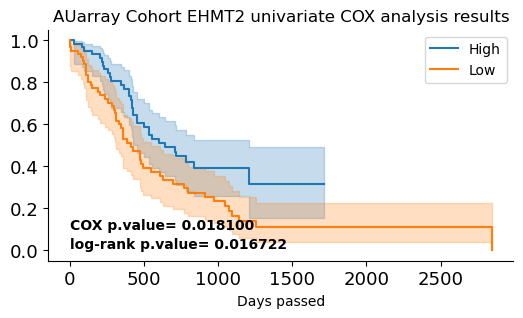

→ Gen: PRMT7
Proportional hazard assumption looks okay.


<lifelines.CoxPHFitter: fitted with 121 total observations, 39 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 121
number of events observed = 82
   partial log-likelihood = -329.59
         time fit was run = 2025-07-07 10:14:58 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
PRMT7_levels -0.63      0.53      0.23           -1.07           -0.19                0.34                0.83

              cmp to     z    p  -log2(p)
covariate                                
PRMT7_levels    0.00 -2.79 0.01      7.56
---
Concordance = 0.57
Partial AIC = 661.18
log-likelihood ratio test = 7.83 on 1 df
-log2(p) of ll-ratio test = 7.60



covariate
PRMT7_levels    0.00531
Name: p, dtype: float64


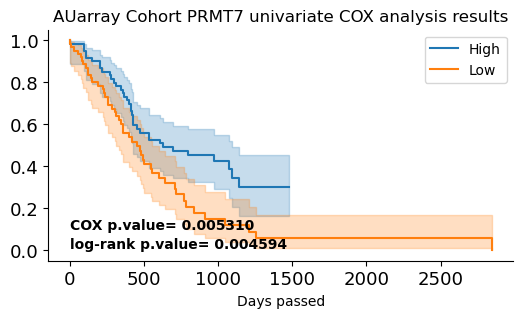


🔎 Análisis univariante en cohorte: AUseq
→ Gen: EHMT2
Proportional hazard assumption looks okay.


<lifelines.CoxPHFitter: fitted with 55 total observations, 20 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 55
number of events observed = 35
   partial log-likelihood = -111.56
         time fit was run = 2025-07-07 10:14:58 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
EHMT2_levels -0.21      0.81      0.35           -0.89            0.47                0.41                1.59

              cmp to     z    p  -log2(p)
covariate                                
EHMT2_levels    0.00 -0.62 0.54      0.90
---
Concordance = 0.55
Partial AIC = 225.12
log-likelihood ratio test = 0.38 on 1 df
-log2(p) of ll-ratio test = 0.90



covariate
EHMT2_levels    0.53701
Name: p, dtype: float64


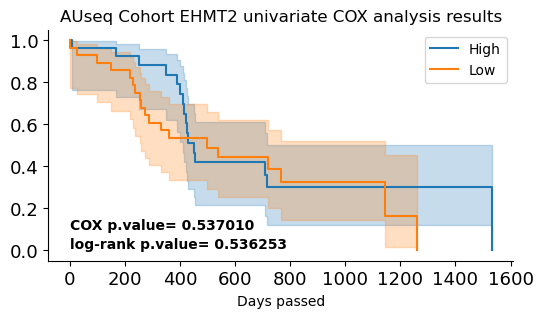

→ Gen: PRMT7
Proportional hazard assumption looks okay.


<lifelines.CoxPHFitter: fitted with 55 total observations, 20 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 55
number of events observed = 35
   partial log-likelihood = -111.70
         time fit was run = 2025-07-07 10:14:59 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
PRMT7_levels  0.12      1.13      0.36           -0.58            0.82                0.56                2.26

              cmp to    z    p  -log2(p)
covariate                               
PRMT7_levels    0.00 0.33 0.74      0.44
---
Concordance = 0.55
Partial AIC = 225.40
log-likelihood ratio test = 0.11 on 1 df
-log2(p) of ll-ratio test = 0.43



covariate
PRMT7_levels    0.739341
Name: p, dtype: float64


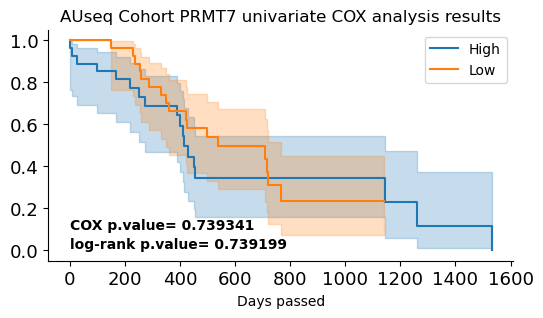


🔎 Análisis univariante en cohorte: CA
→ Gen: EHMT2
Proportional hazard assumption looks okay.


<lifelines.CoxPHFitter: fitted with 122 total observations, 27 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 122
number of events observed = 95
   partial log-likelihood = -383.15
         time fit was run = 2025-07-07 10:14:59 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
EHMT2_levels -0.04      0.96      0.21           -0.45            0.36                0.64                1.44

              cmp to     z    p  -log2(p)
covariate                                
EHMT2_levels    0.00 -0.22 0.83      0.27
---
Concordance = 0.50
Partial AIC = 768.31
log-likelihood ratio test = 0.05 on 1 df
-log2(p) of ll-ratio test = 0.27



covariate
EHMT2_levels    0.828558
Name: p, dtype: float64


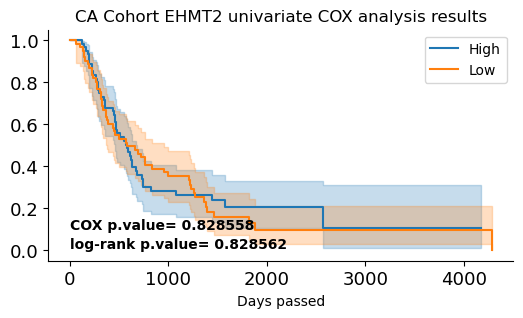

→ Gen: PRMT7
Proportional hazard assumption looks okay.


<lifelines.CoxPHFitter: fitted with 122 total observations, 27 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 122
number of events observed = 95
   partial log-likelihood = -380.78
         time fit was run = 2025-07-07 10:14:59 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
PRMT7_levels -0.46      0.63      0.21           -0.87           -0.05                0.42                0.96

              cmp to     z    p  -log2(p)
covariate                                
PRMT7_levels    0.00 -2.18 0.03      5.09
---
Concordance = 0.55
Partial AIC = 763.55
log-likelihood ratio test = 4.80 on 1 df
-log2(p) of ll-ratio test = 5.14



covariate
PRMT7_levels    0.029291
Name: p, dtype: float64


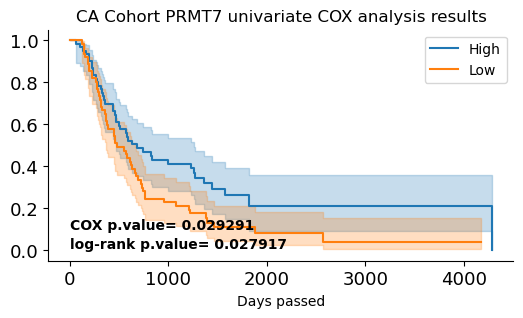


🔎 Análisis univariante en cohorte: TCGA
→ Gen: EHMT2
Proportional hazard assumption looks okay.


<lifelines.CoxPHFitter: fitted with 139 total observations, 58 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 139
number of events observed = 81
   partial log-likelihood = -328.24
         time fit was run = 2025-07-07 10:15:00 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
EHMT2_levels -0.47      0.62      0.23           -0.92           -0.02                0.40                0.98

              cmp to     z    p  -log2(p)
covariate                                
EHMT2_levels    0.00 -2.06 0.04      4.66
---
Concordance = 0.54
Partial AIC = 658.47
log-likelihood ratio test = 4.31 on 1 df
-log2(p) of ll-ratio test = 4.73



covariate
EHMT2_levels    0.039432
Name: p, dtype: float64


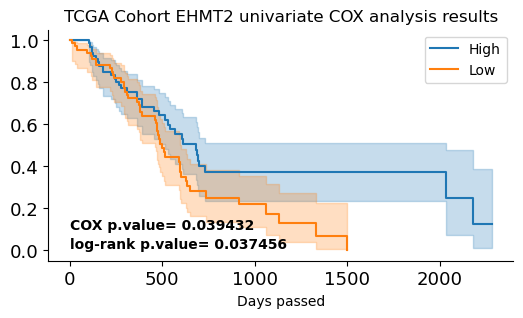

→ Gen: PRMT7
Proportional hazard assumption looks okay.


<lifelines.CoxPHFitter: fitted with 139 total observations, 58 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 139
number of events observed = 81
   partial log-likelihood = -329.58
         time fit was run = 2025-07-07 10:15:00 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
PRMT7_levels -0.29      0.75      0.22           -0.73            0.15                0.48                1.17

              cmp to     z    p  -log2(p)
covariate                                
PRMT7_levels    0.00 -1.27 0.20      2.30
---
Concordance = 0.55
Partial AIC = 661.16
log-likelihood ratio test = 1.63 on 1 df
-log2(p) of ll-ratio test = 2.31



covariate
PRMT7_levels    0.203521
Name: p, dtype: float64


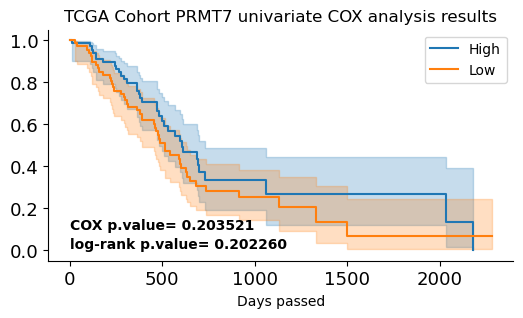


🔎 Análisis univariante en cohorte: CPTAC
→ Gen: EHMT2
Proportional hazard assumption looks okay.


<lifelines.CoxPHFitter: fitted with 129 total observations, 57 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 129
number of events observed = 72
   partial log-likelihood = -300.20
         time fit was run = 2025-07-07 10:15:00 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
EHMT2_levels -0.28      0.76      0.25           -0.76            0.21                0.47                1.23

              cmp to     z    p  -log2(p)
covariate                                
EHMT2_levels    0.00 -1.13 0.26      1.94
---
Concordance = 0.55
Partial AIC = 602.41
log-likelihood ratio test = 1.28 on 1 df
-log2(p) of ll-ratio test = 1.95



covariate
EHMT2_levels    0.260403
Name: p, dtype: float64


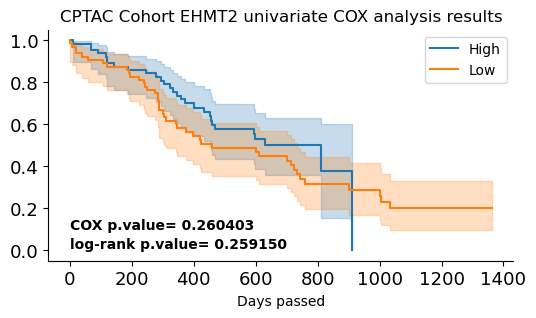

→ Gen: PRMT7
Proportional hazard assumption looks okay.


<lifelines.CoxPHFitter: fitted with 129 total observations, 57 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 129
number of events observed = 72
   partial log-likelihood = -299.91
         time fit was run = 2025-07-07 10:15:01 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
PRMT7_levels -0.32      0.72      0.24           -0.79            0.14                0.45                1.15

              cmp to     z    p  -log2(p)
covariate                                
PRMT7_levels    0.00 -1.36 0.17      2.53
---
Concordance = 0.54
Partial AIC = 601.82
log-likelihood ratio test = 1.87 on 1 df
-log2(p) of ll-ratio test = 2.54



covariate
PRMT7_levels    0.172899
Name: p, dtype: float64


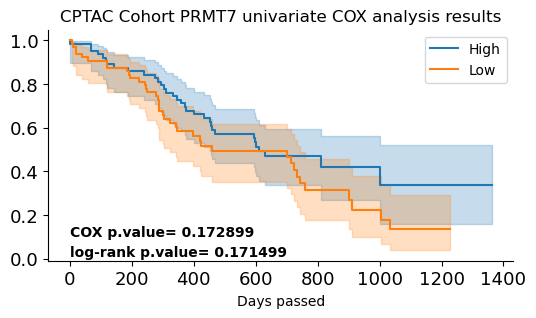


🔎 Análisis univariante en cohorte: Compass
→ Gen: EHMT2
The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 194 total observations, 51 right-censored observations>
         test_name = proportional_hazard_test

---
                   test_statistic    p  -log2(p)
EHMT2_levels km              4.92 0.03      5.24
             rank            5.40 0.02      5.64



1. Variable 'EHMT2_levels' failed the non-proportional test: p-value is 0.0201.

   Advice: with so few unique values (only 2), you can include `strata=['EHMT2_levels', ...]` in the
call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



<lifelines.CoxPHFitter: fitted with 194 total observations, 51 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 194
number of events observed = 143
   partial log-likelihood = -636.56
         time fit was run = 2025-07-07 10:15:01 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
EHMT2_levels -0.09      0.91      0.17           -0.42            0.24                0.66                1.27

              cmp to     z    p  -log2(p)
covariate                                
EHMT2_levels    0.00 -0.53 0.59      0.75
---
Concordance = 0.54
Partial AIC = 1275.12
log-likelihood ratio test = 0.29 on 1 df
-log2(p) of ll-ratio test = 0.75



covariate
EHMT2_levels    0.592738
Name: p, dtype: float64


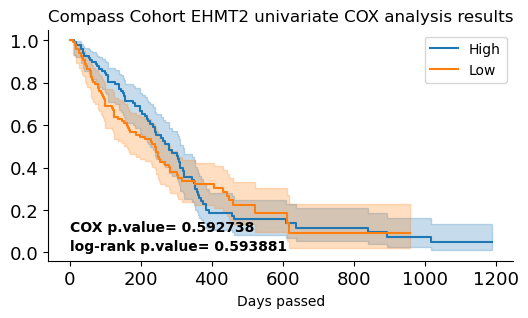

→ Gen: PRMT7
Proportional hazard assumption looks okay.


<lifelines.CoxPHFitter: fitted with 194 total observations, 51 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 194
number of events observed = 143
   partial log-likelihood = -636.49
         time fit was run = 2025-07-07 10:15:02 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
PRMT7_levels  0.11      1.12      0.17           -0.22            0.44                0.80                1.56

              cmp to    z    p  -log2(p)
covariate                               
PRMT7_levels    0.00 0.66 0.51      0.98
---
Concordance = 0.52
Partial AIC = 1274.97
log-likelihood ratio test = 0.44 on 1 df
-log2(p) of ll-ratio test = 0.98



covariate
PRMT7_levels    0.508025
Name: p, dtype: float64


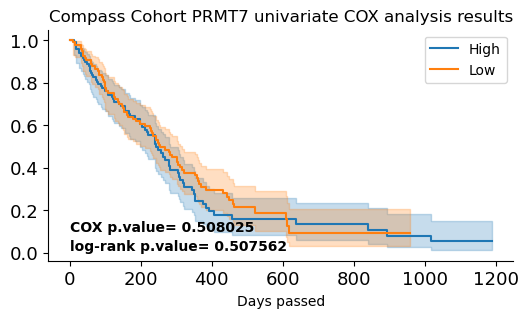

In [28]:
genes_interes = ['EHMT2', 'PRMT7']
tiempo = 'Tiempo'
evento = 'Supervivencia'

resultados_uni = {}

for cohort_name, df in reformatted['Full data'].items():
    print(f'\n🔎 Análisis univariante en cohorte: {cohort_name}')
    resultados_uni[cohort_name] = {}
    for gen in genes_interes:
        try:
            print(f'→ Gen: {gen}')
            resultado = AnalisisMultiCox(
                df,
                Genes=gen,
                Features=[],  # sin variables clínicas
                Time=tiempo,
                Survival=evento,
                Key=cohort_name,
                Mode='Uni'
            )
            resultados_uni[cohort_name][gen] = resultado
        except Exception as e:
            print(f'⚠️ Error en {cohort_name} con {gen}: {e}')



🧬 ANÁLISIS DE EHMT2 POR SUBTIPO MOLECULAR

AUarray: Usando columna 'Subtipo molecular' para EHMT2
   Distribución subtipos: {0.0: 108, 1.0: 17}
   Clásico: n=108, μ=2.694
   Basal: n=17, μ=2.784
   p-valor: 6.50e-01

AUseq: Usando columna 'Subtipo molecular' para EHMT2
   Distribución subtipos: {0.0: 49, 1.0: 7}
   Clásico: n=49, μ=2.696
   Basal: n=7, μ=2.812
   p-valor: 6.97e-01

CA: Usando columna 'Subtipo molecular' para EHMT2
   Distribución subtipos: {0.0: 128, 1.0: 35}
   Clásico: n=128, μ=2.687
   Basal: n=35, μ=2.772
   p-valor: 5.50e-01

TCGA: Usando columna 'Subtipo molecular' para EHMT2
   Distribución subtipos: {0.0: 107, 1.0: 34}
   Clásico: n=107, μ=2.643
   Basal: n=34, μ=2.897
   p-valor: 8.36e-02

📈 ANÁLISIS DE SIGNIFICANCIA ESTADÍSTICA PARA EHMT2:
   🔢 Total de cohortes analizadas: 4
   ✅ Cohortes con diferencias significativas (p < 0.05): 0/4
   ❌ Ninguna cohorte mostró diferencias significativas

📊 RESUMEN EHMT2 (ordenado por p-valor):
----------------------------

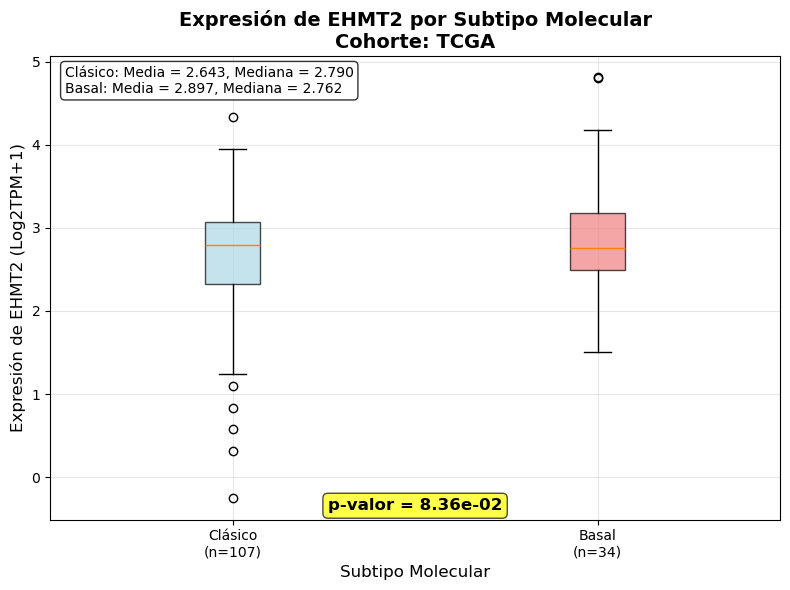

✅ Boxplot mostrado para EHMT2 en cohorte TCGA

🧬 ANÁLISIS DE PRMT7 POR SUBTIPO MOLECULAR

AUarray: Usando columna 'Subtipo molecular' para PRMT7
   Distribución subtipos: {0.0: 108, 1.0: 17}
   Clásico: n=108, μ=3.718
   Basal: n=17, μ=3.309
   p-valor: 1.14e-01

AUseq: Usando columna 'Subtipo molecular' para PRMT7
   Distribución subtipos: {0.0: 49, 1.0: 7}
   Clásico: n=49, μ=3.636
   Basal: n=7, μ=4.116
   p-valor: 2.18e-01

CA: Usando columna 'Subtipo molecular' para PRMT7
   Distribución subtipos: {0.0: 128, 1.0: 35}
   Clásico: n=128, μ=3.731
   Basal: n=35, μ=3.430
   p-valor: 1.03e-01

TCGA: Usando columna 'Subtipo molecular' para PRMT7
   Distribución subtipos: {0.0: 107, 1.0: 34}
   Clásico: n=107, μ=3.728
   Basal: n=34, μ=3.464
   p-valor: 1.70e-01

📈 ANÁLISIS DE SIGNIFICANCIA ESTADÍSTICA PARA PRMT7:
   🔢 Total de cohortes analizadas: 4
   ✅ Cohortes con diferencias significativas (p < 0.05): 0/4
   ❌ Ninguna cohorte mostró diferencias significativas

📊 RESUMEN PRMT7 (orden

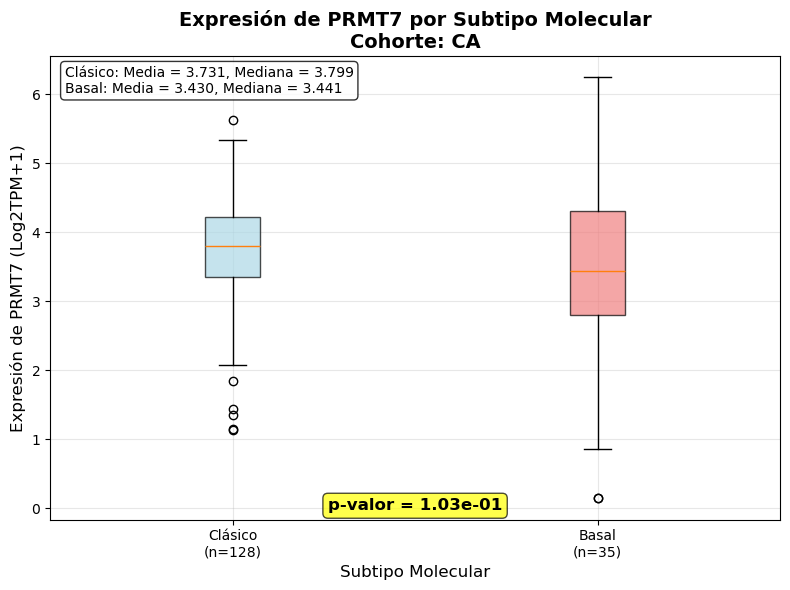

✅ Boxplot mostrado para PRMT7 en cohorte CA

🔬 ANÁLISIS COMPLETADO - SUBTIPO MOLECULAR


In [29]:
# Análisis separado para EHMT2 y PRMT7 por subtipo molecular
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Configuración con nombres correctos de cohortes
cohorts_data = {
    'AUarray': df1,
    'AUseq': df2,
    'CA': df3,
    'TCGA': df4
}

# Análisis para cada gen por separado
for gene_analisis in ['EHMT2', 'PRMT7']:
    print(f"\n{'='*80}")
    print(f"🧬 ANÁLISIS DE {gene_analisis} POR SUBTIPO MOLECULAR")
    print(f"{'='*80}")
    
    resultados_gene = []
    
    # Evaluación en cada cohorte
    for cohort_name, df_cohort in cohorts_data.items():
        # Buscar columna de subtipo molecular
        potential_cols = [col for col in df_cohort.columns if 'molecular' in col.lower() or 'subtype' in col.lower()]
        if not potential_cols:
            potential_cols = [col for col in df_cohort.columns if any(x in col.lower() for x in ['basal', 'clasico'])]
        
        if potential_cols and gene_analisis in df_cohort.columns:
            subtipo_col = potential_cols[0]
            print(f"\n{cohort_name}: Usando columna '{subtipo_col}' para {gene_analisis}")
            
            # Verificar valores únicos
            valores_unicos = df_cohort[subtipo_col].value_counts()
            print(f"   Distribución subtipos: {dict(valores_unicos)}")
            
            # Solo continuar si hay valores 0 y 1 (clásico y basal)
            if 0 in valores_unicos.index and 1 in valores_unicos.index:
                # Filtrar datos válidos
                mask = (df_cohort[subtipo_col].isin([0, 1])) & (df_cohort[gene_analisis].notna())
                if mask.sum() > 10:  # Mínimo 10 pacientes
                    data_clasico = df_cohort[mask & (df_cohort[subtipo_col] == 0)][gene_analisis]
                    data_basal = df_cohort[mask & (df_cohort[subtipo_col] == 1)][gene_analisis]
                    
                    # t-test
                    t_stat, p_value = ttest_ind(data_clasico, data_basal)
                    
                    resultados_gene.append({
                        'cohort': cohort_name,
                        'p_value': p_value,
                        'n_clasico': len(data_clasico),
                        'n_basal': len(data_basal),
                        'mean_clasico': data_clasico.mean(),
                        'mean_basal': data_basal.mean(),
                        'data_clasico': data_clasico,
                        'data_basal': data_basal,
                        'subtipo_col': subtipo_col
                    })
                    
                    print(f"   Clásico: n={len(data_clasico)}, μ={data_clasico.mean():.3f}")
                    print(f"   Basal: n={len(data_basal)}, μ={data_basal.mean():.3f}")
                    print(f"   p-valor: {p_value:.2e}")
    
    # Análisis de significancia estadística
    if resultados_gene:
        total_cohortes = len(resultados_gene)
        cohortes_significativas = [r['cohort'] for r in resultados_gene if r['p_value'] < 0.05]
        n_significativas = len(cohortes_significativas)
        
        print(f"\n📈 ANÁLISIS DE SIGNIFICANCIA ESTADÍSTICA PARA {gene_analisis}:")
        print(f"   🔢 Total de cohortes analizadas: {total_cohortes}")
        print(f"   ✅ Cohortes con diferencias significativas (p < 0.05): {n_significativas}/{total_cohortes}")
        
        if n_significativas > 0:
            print(f"   📋 Cohortes significativas: {', '.join(cohortes_significativas)}")
            # Mostrar p-valores de las significativas
            for cohort in cohortes_significativas:
                p_val = next(r['p_value'] for r in resultados_gene if r['cohort'] == cohort)
                print(f"      • {cohort}: p = {p_val:.3e}")
        else:
            print(f"   ❌ Ninguna cohorte mostró diferencias significativas")
        
        # Mostrar resumen y seleccionar mejor resultado
        df_resultados = pd.DataFrame([{k: v for k, v in r.items() if k not in ['data_clasico', 'data_basal', 'subtipo_col']} 
                                     for r in resultados_gene])
        df_resultados = df_resultados.sort_values('p_value')
        
        print(f"\n📊 RESUMEN {gene_analisis} (ordenado por p-valor):")
        print("-" * 60)
        for _, row in df_resultados.iterrows():
            significancia = "✅" if row['p_value'] < 0.05 else "❌"
            print(f"{significancia} {row['cohort']}: p={row['p_value']:.2e} "
                  f"(Clásico: n={row['n_clasico']}, μ={row['mean_clasico']:.3f}; "
                  f"Basal: n={row['n_basal']}, μ={row['mean_basal']:.3f})")
        
        # Mejor resultado para este gen
        best_idx = df_resultados.index[0]
        best_result = resultados_gene[best_idx]
        mejor_cohort = best_result['cohort']
        mejor_p = best_result['p_value']
        
        print(f"\n🎯 MEJOR RESULTADO {gene_analisis}: {mejor_cohort} (p = {mejor_p:.2e})")
        
        # Crear boxplot para el mejor resultado
        data_plot = [best_result['data_clasico'], best_result['data_basal']]
        labels_plot = [f"Clásico\n(n={len(best_result['data_clasico'])})", 
                      f"Basal\n(n={len(best_result['data_basal'])})"]
        
        plt.figure(figsize=(8, 6))
        bp = plt.boxplot(data_plot, tick_labels=labels_plot, patch_artist=True)
        
        # Personalizar colores
        colors = ['lightblue', 'lightcoral']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        # Añadir estadísticas en el gráfico
        medians = [np.median(data) for data in data_plot]
        means = [np.mean(data) for data in data_plot]
        
        stats_text = (f"Clásico: Media = {means[0]:.3f}, Mediana = {medians[0]:.3f}\n"
                      f"Basal: Media = {means[1]:.3f}, Mediana = {medians[1]:.3f}")
        
        plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
                 verticalalignment='top', fontsize=10,
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Añadir p-valor prominente
        p_text = f'p-valor = {mejor_p:.2e}'
        if mejor_p < 0.001:
            p_text += ' ***'
        elif mejor_p < 0.01:
            p_text += ' **'
        elif mejor_p < 0.05:
            p_text += ' *'
        
        plt.text(0.5, 0.02, p_text, transform=plt.gca().transAxes, 
                 horizontalalignment='center', fontsize=12, fontweight='bold',
                 bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
        
        # Etiquetas y título
        plt.ylabel(f'Expresión de {gene_analisis} (Log2TPM+1)', fontsize=12)
        plt.xlabel('Subtipo Molecular', fontsize=12)
        plt.title(f'Expresión de {gene_analisis} por Subtipo Molecular\nCohorte: {mejor_cohort}', 
                  fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"✅ Boxplot mostrado para {gene_analisis} en cohorte {mejor_cohort}")
    
    else:
        print(f"❌ No se encontraron datos válidos para {gene_analisis}")

print(f"\n{'='*80}")
print("🔬 ANÁLISIS COMPLETADO - SUBTIPO MOLECULAR")
print(f"{'='*80}")


🧬 ANÁLISIS DE EHMT2 POR ESTADIO AGRUPADO

AUarray: Usando columna 'Estadío agrupado' para EHMT2
   Distribución estadios: {1.0: 89, 0.0: 35}
   Temprano: n=35, μ=2.801
   Avanzado: n=89, μ=2.667
   p-valor: 3.75e-01

AUseq: Usando columna 'Estadío agrupado' para EHMT2
   Distribución estadios: {1.0: 43, 0.0: 13}
   Temprano: n=13, μ=2.650
   Avanzado: n=43, μ=2.729
   p-valor: 7.39e-01

CA: Usando columna 'Estadío agrupado' para EHMT2
   Distribución estadios: {0.0: 71, 1.0: 54}
   Temprano: n=71, μ=2.787
   Avanzado: n=54, μ=2.689
   p-valor: 4.24e-01

TCGA: Usando columna 'Estadío agrupado' para EHMT2
   Distribución estadios: {1.0: 105, 0.0: 35}
   Temprano: n=35, μ=2.847
   Avanzado: n=105, μ=2.655
   p-valor: 1.92e-01

📈 ANÁLISIS DE SIGNIFICANCIA ESTADÍSTICA PARA EHMT2:
   🔢 Total de cohortes analizadas: 4
   ✅ Cohortes con diferencias significativas (p < 0.05): 0/4
   ❌ Ninguna cohorte mostró diferencias significativas

📊 RESUMEN EHMT2 (ordenado por p-valor):
-------------------

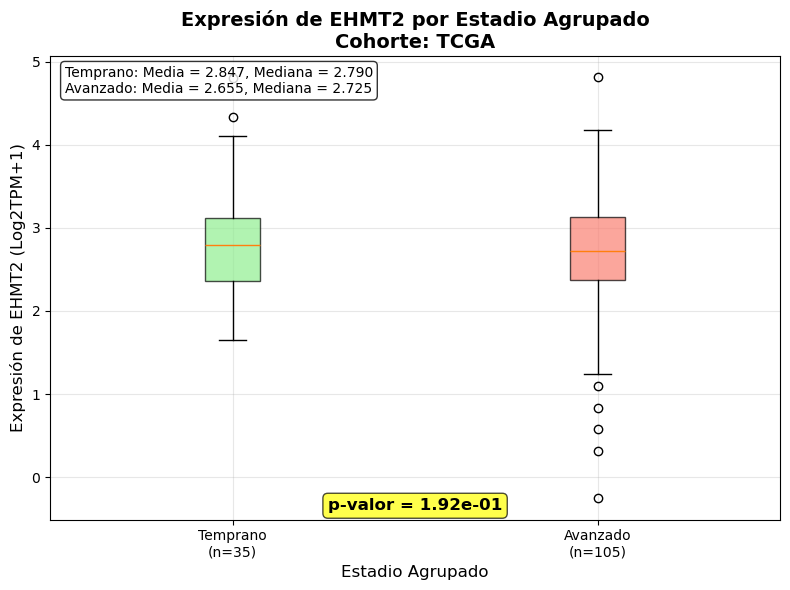

✅ Boxplot mostrado para EHMT2 en cohorte TCGA

🧬 ANÁLISIS DE PRMT7 POR ESTADIO AGRUPADO

AUarray: Usando columna 'Estadío agrupado' para PRMT7
   Distribución estadios: {1.0: 89, 0.0: 35}
   Temprano: n=35, μ=4.019
   Avanzado: n=89, μ=3.525
   p-valor: 1.23e-02

AUseq: Usando columna 'Estadío agrupado' para PRMT7
   Distribución estadios: {1.0: 43, 0.0: 13}
   Temprano: n=13, μ=3.923
   Avanzado: n=43, μ=3.627
   p-valor: 3.34e-01

CA: Usando columna 'Estadío agrupado' para PRMT7
   Distribución estadios: {0.0: 71, 1.0: 54}
   Temprano: n=71, μ=3.828
   Avanzado: n=54, μ=3.594
   p-valor: 1.47e-01

TCGA: Usando columna 'Estadío agrupado' para PRMT7
   Distribución estadios: {1.0: 105, 0.0: 35}
   Temprano: n=35, μ=3.962
   Avanzado: n=105, μ=3.560
   p-valor: 3.46e-02

📈 ANÁLISIS DE SIGNIFICANCIA ESTADÍSTICA PARA PRMT7:
   🔢 Total de cohortes analizadas: 4
   ✅ Cohortes con diferencias significativas (p < 0.05): 2/4
   📋 Cohortes significativas: AUarray, TCGA
      • AUarray: p = 1.23

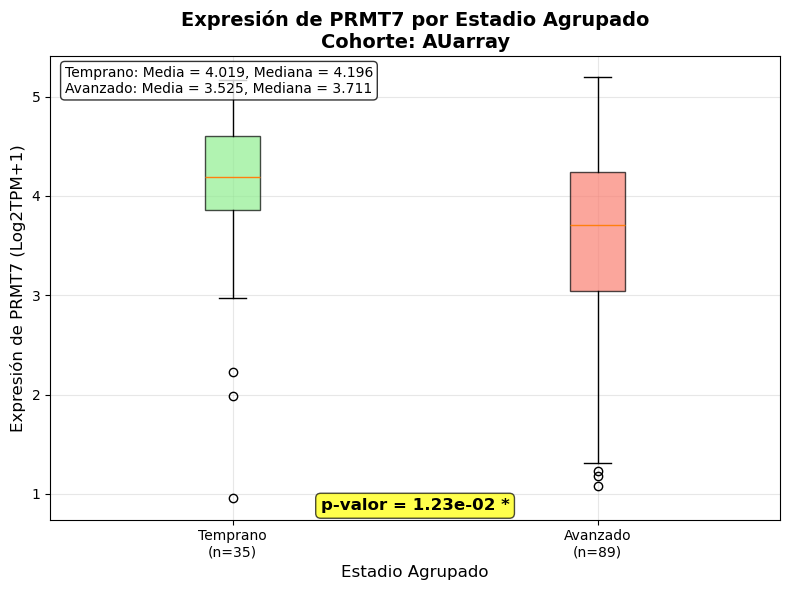

✅ Boxplot mostrado para PRMT7 en cohorte AUarray

🔬 ANÁLISIS COMPLETADO - ESTADIO AGRUPADO


In [30]:
# Análisis separado para EHMT2 y PRMT7 por estadio agrupado
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Configuración con nombres correctos de cohortes
cohorts_data = {
    'AUarray': df1,
    'AUseq': df2,
    'CA': df3,
    'TCGA': df4
}

# Análisis para cada gen por separado
for gene_analisis in ['EHMT2', 'PRMT7']:
    print(f"\n{'='*80}")
    print(f"🧬 ANÁLISIS DE {gene_analisis} POR ESTADIO AGRUPADO")
    print(f"{'='*80}")
    
    resultados_gene = []
    
    # Evaluación en cada cohorte
    for cohort_name, df_cohort in cohorts_data.items():
        # Buscar columna de estadio agrupado
        potential_cols = [col for col in df_cohort.columns if 'estadio' in col.lower() or 'estadío' in col.lower() or 'stage' in col.lower()]
        if not potential_cols:
            potential_cols = [col for col in df_cohort.columns if any(x in col.lower() for x in ['agrupado', 'grouped'])]
        
        if potential_cols and gene_analisis in df_cohort.columns:
            estadio_col = potential_cols[0]
            print(f"\n{cohort_name}: Usando columna '{estadio_col}' para {gene_analisis}")
            
            # Verificar valores únicos
            valores_unicos = df_cohort[estadio_col].value_counts()
            print(f"   Distribución estadios: {dict(valores_unicos)}")
            
            # Solo continuar si hay valores 0 y 1 (temprano y avanzado)
            if 0 in valores_unicos.index and 1 in valores_unicos.index:
                # Filtrar datos válidos
                mask = (df_cohort[estadio_col].isin([0, 1])) & (df_cohort[gene_analisis].notna())
                if mask.sum() > 10:  # Mínimo 10 pacientes
                    data_temprano = df_cohort[mask & (df_cohort[estadio_col] == 0)][gene_analisis]
                    data_avanzado = df_cohort[mask & (df_cohort[estadio_col] == 1)][gene_analisis]
                    
                    # t-test
                    t_stat, p_value = ttest_ind(data_temprano, data_avanzado)
                    
                    resultados_gene.append({
                        'cohort': cohort_name,
                        'p_value': p_value,
                        'n_temprano': len(data_temprano),
                        'n_avanzado': len(data_avanzado),
                        'mean_temprano': data_temprano.mean(),
                        'mean_avanzado': data_avanzado.mean(),
                        'data_temprano': data_temprano,
                        'data_avanzado': data_avanzado,
                        'estadio_col': estadio_col
                    })
                    
                    print(f"   Temprano: n={len(data_temprano)}, μ={data_temprano.mean():.3f}")
                    print(f"   Avanzado: n={len(data_avanzado)}, μ={data_avanzado.mean():.3f}")
                    print(f"   p-valor: {p_value:.2e}")
    
    # Análisis de significancia estadística
    if resultados_gene:
        total_cohortes = len(resultados_gene)
        cohortes_significativas = [r['cohort'] for r in resultados_gene if r['p_value'] < 0.05]
        n_significativas = len(cohortes_significativas)
        
        print(f"\n📈 ANÁLISIS DE SIGNIFICANCIA ESTADÍSTICA PARA {gene_analisis}:")
        print(f"   🔢 Total de cohortes analizadas: {total_cohortes}")
        print(f"   ✅ Cohortes con diferencias significativas (p < 0.05): {n_significativas}/{total_cohortes}")
        
        if n_significativas > 0:
            print(f"   📋 Cohortes significativas: {', '.join(cohortes_significativas)}")
            # Mostrar p-valores de las significativas
            for cohort in cohortes_significativas:
                p_val = next(r['p_value'] for r in resultados_gene if r['cohort'] == cohort)
                print(f"      • {cohort}: p = {p_val:.3e}")
        else:
            print(f"   ❌ Ninguna cohorte mostró diferencias significativas")
        
        # Mostrar resumen y seleccionar mejor resultado
        df_resultados = pd.DataFrame([{k: v for k, v in r.items() if k not in ['data_temprano', 'data_avanzado', 'estadio_col']} 
                                     for r in resultados_gene])
        df_resultados = df_resultados.sort_values('p_value')
        
        print(f"\n📊 RESUMEN {gene_analisis} (ordenado por p-valor):")
        print("-" * 60)
        for _, row in df_resultados.iterrows():
            significancia = "✅" if row['p_value'] < 0.05 else "❌"
            print(f"{significancia} {row['cohort']}: p={row['p_value']:.2e} "
                  f"(Temprano: n={row['n_temprano']}, μ={row['mean_temprano']:.3f}; "
                  f"Avanzado: n={row['n_avanzado']}, μ={row['mean_avanzado']:.3f})")
        
        # Mejor resultado para este gen
        best_idx = df_resultados.index[0]
        best_result = resultados_gene[best_idx]
        mejor_cohort = best_result['cohort']
        mejor_p = best_result['p_value']
        
        print(f"\n🎯 MEJOR RESULTADO {gene_analisis}: {mejor_cohort} (p = {mejor_p:.2e})")
        
        # Crear boxplot para el mejor resultado
        data_plot = [best_result['data_temprano'], best_result['data_avanzado']]
        labels_plot = [f"Temprano\n(n={len(best_result['data_temprano'])})", 
                      f"Avanzado\n(n={len(best_result['data_avanzado'])})"]
        
        plt.figure(figsize=(8, 6))
        bp = plt.boxplot(data_plot, tick_labels=labels_plot, patch_artist=True)
        
        # Personalizar colores
        colors = ['lightgreen', 'salmon']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        # Añadir estadísticas en el gráfico
        medians = [np.median(data) for data in data_plot]
        means = [np.mean(data) for data in data_plot]
        
        stats_text = (f"Temprano: Media = {means[0]:.3f}, Mediana = {medians[0]:.3f}\n"
                      f"Avanzado: Media = {means[1]:.3f}, Mediana = {medians[1]:.3f}")
        
        plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
                 verticalalignment='top', fontsize=10,
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Añadir p-valor prominente
        p_text = f'p-valor = {mejor_p:.2e}'
        if mejor_p < 0.001:
            p_text += ' ***'
        elif mejor_p < 0.01:
            p_text += ' **'
        elif mejor_p < 0.05:
            p_text += ' *'
        
        plt.text(0.5, 0.02, p_text, transform=plt.gca().transAxes, 
                 horizontalalignment='center', fontsize=12, fontweight='bold',
                 bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
        
        # Etiquetas y título
        plt.ylabel(f'Expresión de {gene_analisis} (Log2TPM+1)', fontsize=12)
        plt.xlabel('Estadio Agrupado', fontsize=12)
        plt.title(f'Expresión de {gene_analisis} por Estadio Agrupado\nCohorte: {mejor_cohort}', 
                  fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"✅ Boxplot mostrado para {gene_analisis} en cohorte {mejor_cohort}")
    
    else:
        print(f"❌ No se encontraron datos válidos para {gene_analisis}")

print(f"\n{'='*80}")
print("🔬 ANÁLISIS COMPLETADO - ESTADIO AGRUPADO")
print(f"{'='*80}")

<h2> Análisis Cox Multivariante <h2>


📊 Ejecutando modelo multivariante en: AUarray
['EHMT2', 'PRMT7', 'Edad', 'Sexo', 'Estadío agrupado', 'Subtipo molecular']
The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 121 total observations, 39 right-censored observations>
         test_name = proportional_hazard_test

---
                        test_statistic      p  -log2(p)
EHMT2_levels      km              0.56   0.45      1.14
                  rank            0.70   0.40      1.31
Edad              km              2.97   0.08      3.56
                  rank            3.09   0.08      3.66
Estadío agrupado  km             11.55 <0.005     10.52
                  rank           12.13 <0.005     10.98
PRMT7_levels      km              0.70   0.40      1.31
                  rank            0.78   0.38      1.40
Sexo              km              0.00   0.97      0.05
                  rank            0.01   0.93      0.10
Subtipo molecular km              3.49   0.06      4.02
                  rank            3.86   0.05      4.34



1. Variable 'Estadío agrupado' failed the non-proportional test: p-value is 0.0005.

   Advice: with so few unique values (only 2), you can include `strata=['Estadío agrupado', ...]` in
the call in `.fit`. See documentation in link [E] below.

2. Variable 'Subtipo molecular' failed the non-proportional test: p-value is 0.0495.

   Advice: with so few unique values (only 2), you can include `strata=['Subtipo molecular', ...]`
in the call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-fun

<lifelines.CoxPHFitter: fitted with 121 total observations, 39 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 121
number of events observed = 82
   partial log-likelihood = -317.37
         time fit was run = 2025-07-07 10:46:46 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
Edad               0.03      1.03      0.01            0.01            0.06                1.01                1.06
Sexo               0.29      1.34      0.24           -0.18            0.76                0.84                2.15
Estadío agrupado   0.72      2.06      0.32            0.10            1.34                1.11                3.82
Subtipo molecular  0.87      2.38      0.33            0.22            1.51                1.25                4.52
EHMT2_levels      -0.69      0.50      0.24           -1.16           -0.23                0.31                0.80
PRMT7_levels      -0.49      0.61      0.25           -0.98           -0.01                0.38                0.99

                   cmp to     z      p  -log2(p)
covariate                                       
Edad                 0.00  2.47   0.01      6.19
Sexo                 0.00  1.22   0.22      2.17
Estadío agrupado     0.00  2.29   0.02      5.49
Subtipo molecular    0.00  2.65   0.01      6.94
EHMT2_levels         0.00 -2.93 <0.005      8.19
PRMT7_levels         0.00 -1.99   0.05      4.44
---
Concordance = 0.68
Partial AIC = 646.74
log-likelihood ratio test = 32.27 on 6 df
-log2(p) of ll-ratio test = 16.08



covariate
Edad                 0.013667
Sexo                 0.222372
Estadío agrupado     0.022296
Subtipo molecular    0.008169
EHMT2_levels         0.003428
PRMT7_levels         0.046176
Name: p, dtype: float64


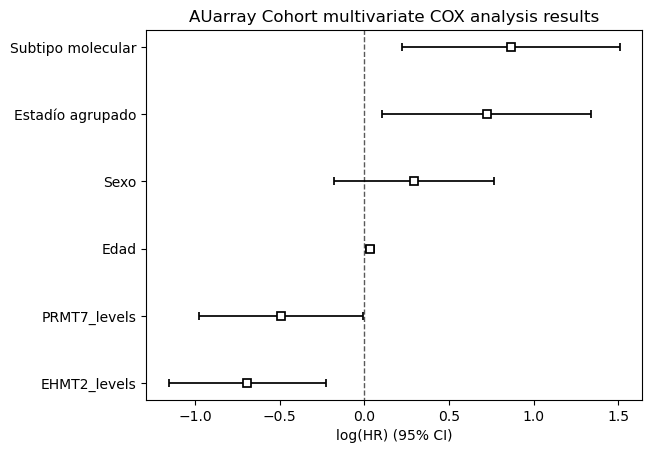

                     HR  p-value  Coef_low  Coef_high
EHMT2              0.50   0.0034      0.31       0.80
PRMT7              0.61   0.0462      0.38       0.99
Edad               1.03   0.0137      1.01       1.06
Sexo               1.34   0.2224      0.84       2.15
Estadío agrupado   2.06   0.0223      1.11       3.82
Subtipo molecular  2.38   0.0082      1.25       4.52

📊 Ejecutando modelo multivariante en: AUseq
['EHMT2', 'PRMT7', 'Edad', 'Sexo', 'Estadío agrupado', 'Subtipo molecular']
The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 55 total observations, 20 right-censored observations>
         test_name = proportional_hazard_test

---
                        test_statistic    p  -log2(p)
EHMT2_levels      km              1.54 0.21      2.22
                  rank            2.65 0.10      3.28
Edad              km              0.73 0.39      1.35
                  rank            0.74 0.39      1.36
Estadío agrupado  km              1.81 0.18      2.49
                  rank            2.59 0.11      3.22
PRMT7_levels      km              5.56 0.02      5.76
                  rank            7.37 0.01      7.23
Sexo              km              3.51 0.06      4.03
                  rank            4.24 0.04      4.66
Subtipo molecular km              0.85 0.36      1.48
                  rank            1.09 0.30      1.76



1. Variable 'Sexo' failed the non-proportional test: p-value is 0.0395.

   Advice: with so few unique values (only 2), you can include `strata=['Sexo', ...]` in the call in
`.fit`. See documentation in link [E] below.

2. Variable 'PRMT7_levels' failed the non-proportional test: p-value is 0.0066.

   Advice: with so few unique values (only 2), you can include `strata=['PRMT7_levels', ...]` in the
call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifeline

<lifelines.CoxPHFitter: fitted with 55 total observations, 20 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 55
number of events observed = 35
   partial log-likelihood = -109.50
         time fit was run = 2025-07-07 10:46:46 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
Edad               0.01      1.01      0.02           -0.03            0.04                0.97                1.04
Sexo              -0.01      0.99      0.37           -0.73            0.70                0.48                2.02
Estadío agrupado   0.46      1.58      0.47           -0.46            1.38                0.63                3.96
Subtipo molecular  0.74      2.09      0.50           -0.25            1.72                0.78                5.58
EHMT2_levels      -0.36      0.70      0.37           -1.09            0.37                0.34                1.44
PRMT7_levels       0.30      1.36      0.40           -0.48            1.09                0.62                2.96

                   cmp to     z    p  -log2(p)
covariate                                     
Edad                 0.00  0.29 0.78      0.37
Sexo                 0.00 -0.04 0.97      0.05
Estadío agrupado     0.00  0.98 0.33      1.61
Subtipo molecular    0.00  1.47 0.14      2.82
EHMT2_levels         0.00 -0.97 0.33      1.60
PRMT7_levels         0.00  0.76 0.45      1.17
---
Concordance = 0.64
Partial AIC = 231.01
log-likelihood ratio test = 4.50 on 6 df
-log2(p) of ll-ratio test = 0.71



covariate
Edad                 0.775342
Sexo                 0.967930
Estadío agrupado     0.328427
Subtipo molecular    0.141432
EHMT2_levels         0.330701
PRMT7_levels         0.445202
Name: p, dtype: float64


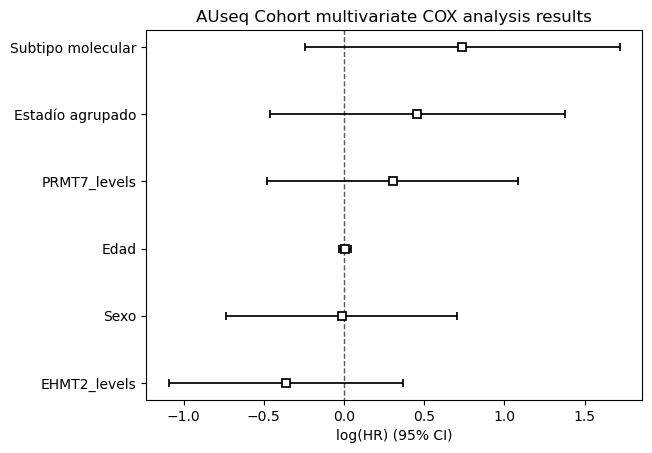

                     HR  p-value  Coef_low  Coef_high
EHMT2              0.70   0.3307      0.34       1.44
PRMT7              1.36   0.4452      0.62       2.96
Edad               1.01   0.7753      0.97       1.04
Sexo               0.99   0.9679      0.48       2.02
Estadío agrupado   1.58   0.3284      0.63       3.96
Subtipo molecular  2.09   0.1414      0.78       5.58

📊 Ejecutando modelo multivariante en: CA
['EHMT2', 'PRMT7', 'Edad', 'Sexo', 'Estadío agrupado', 'Subtipo molecular']
Proportional hazard assumption looks okay.


<lifelines.CoxPHFitter: fitted with 122 total observations, 27 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 122
number of events observed = 95
   partial log-likelihood = -378.64
         time fit was run = 2025-07-07 10:46:46 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
Edad               0.00      1.00      0.01           -0.01            0.02                0.99                1.02
Sexo               0.07      1.07      0.21           -0.34            0.48                0.71                1.62
Estadío agrupado   0.13      1.14      0.21           -0.29            0.54                0.75                1.72
Subtipo molecular  0.51      1.67      0.26            0.01            1.02                1.01                2.76
EHMT2_levels      -0.11      0.89      0.21           -0.54            0.31                0.59                1.36
PRMT7_levels      -0.35      0.71      0.22           -0.78            0.09                0.46                1.09

                   cmp to     z    p  -log2(p)
covariate                                     
Edad                 0.00  0.48 0.63      0.66
Sexo                 0.00  0.33 0.74      0.43
Estadío agrupado     0.00  0.61 0.54      0.88
Subtipo molecular    0.00  2.00 0.05      4.47
EHMT2_levels         0.00 -0.53 0.59      0.75
PRMT7_levels         0.00 -1.57 0.12      3.11
---
Concordance = 0.59
Partial AIC = 769.29
log-likelihood ratio test = 9.06 on 6 df
-log2(p) of ll-ratio test = 2.56



covariate
Edad                 0.631355
Sexo                 0.741670
Estadío agrupado     0.544866
Subtipo molecular    0.045193
EHMT2_levels         0.592781
PRMT7_levels         0.116113
Name: p, dtype: float64


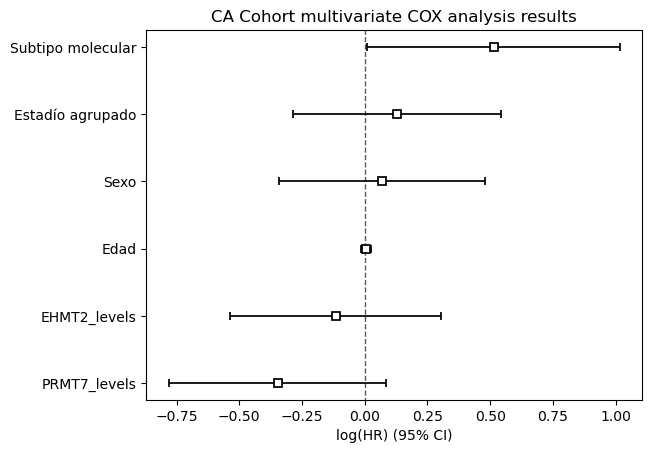

                     HR  p-value  Coef_low  Coef_high
EHMT2              0.89   0.5928      0.59       1.36
PRMT7              0.71   0.1161      0.46       1.09
Edad               1.00   0.6314      0.99       1.02
Sexo               1.07   0.7417      0.71       1.62
Estadío agrupado   1.14   0.5449      0.75       1.72
Subtipo molecular  1.67   0.0452      1.01       2.76

📊 Ejecutando modelo multivariante en: TCGA
['EHMT2', 'PRMT7', 'Edad', 'Sexo', 'Estadío agrupado', 'Subtipo molecular']
The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(.

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 139 total observations, 58 right-censored observations>
         test_name = proportional_hazard_test

---
                        test_statistic      p  -log2(p)
EHMT2_levels      km              2.95   0.09      3.54
                  rank            2.72   0.10      3.33
Edad              km              0.10   0.75      0.41
                  rank            0.14   0.70      0.51
Estadío agrupado  km              0.09   0.77      0.38
                  rank            0.15   0.69      0.53
PRMT7_levels      km              1.50   0.22      2.18
                  rank            1.45   0.23      2.13
Sexo              km              2.39   0.12      3.04
                  rank            2.69   0.10      3.31
Subtipo molecular km              7.67   0.01      7.48
                  rank            9.31 <0.005      8.77



1. Variable 'Subtipo molecular' failed the non-proportional test: p-value is 0.0023.

   Advice: with so few unique values (only 2), you can include `strata=['Subtipo molecular', ...]`
in the call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



<lifelines.CoxPHFitter: fitted with 139 total observations, 58 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 139
number of events observed = 81
   partial log-likelihood = -324.36
         time fit was run = 2025-07-07 10:46:47 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
Edad               0.02      1.02      0.01           -0.01            0.04                0.99                1.04
Sexo              -0.09      0.91      0.23           -0.54            0.36                0.58                1.43
Estadío agrupado   0.29      1.33      0.29           -0.27            0.85                0.76                2.33
Subtipo molecular  0.50      1.64      0.25            0.01            0.98                1.01                2.68
EHMT2_levels      -0.37      0.69      0.24           -0.84            0.10                0.43                1.11
PRMT7_levels      -0.15      0.86      0.24           -0.61            0.32                0.54                1.37

                   cmp to     z    p  -log2(p)
covariate                                     
Edad                 0.00  1.42 0.16      2.67
Sexo                 0.00 -0.39 0.70      0.52
Estadío agrupado     0.00  1.01 0.31      1.67
Subtipo molecular    0.00  2.00 0.05      4.44
EHMT2_levels         0.00 -1.53 0.13      2.99
PRMT7_levels         0.00 -0.63 0.53      0.92
---
Concordance = 0.63
Partial AIC = 660.73
log-likelihood ratio test = 12.06 on 6 df
-log2(p) of ll-ratio test = 4.04



covariate
Edad                 0.156805
Sexo                 0.696042
Estadío agrupado     0.314883
Subtipo molecular    0.046018
EHMT2_levels         0.125466
PRMT7_levels         0.528995
Name: p, dtype: float64


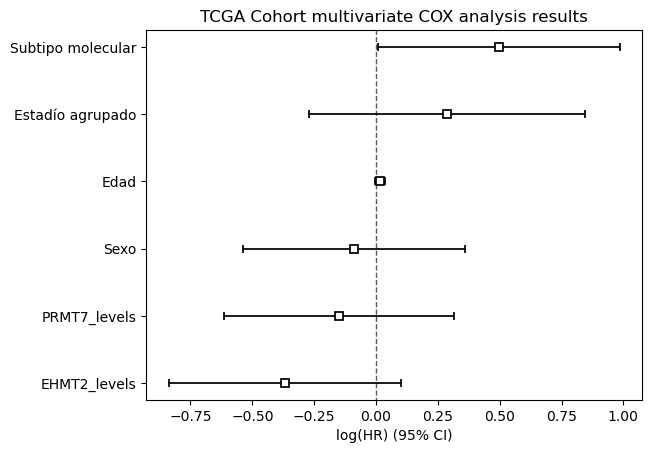

                     HR  p-value  Coef_low  Coef_high
EHMT2              0.69   0.1255      0.43       1.11
PRMT7              0.86   0.5290      0.54       1.37
Edad               1.02   0.1568      0.99       1.04
Sexo               0.91   0.6960      0.58       1.43
Estadío agrupado   1.33   0.3149      0.76       2.33
Subtipo molecular  1.64   0.0460      1.01       2.68

📊 Ejecutando modelo multivariante en: CPTAC
['EHMT2', 'PRMT7', 'Edad', 'Sexo', 'Estadío agrupado', 'Subtipo molecular']
The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 129 total observations, 57 right-censored observations>
         test_name = proportional_hazard_test

---
                   test_statistic    p  -log2(p)
EHMT2_levels km              1.51 0.22      2.19
             rank            1.15 0.28      1.82
Edad         km              3.51 0.06      4.03
             rank            3.98 0.05      4.44
PRMT7_levels km              0.22 0.64      0.64
             rank            0.06 0.81      0.30
Sexo         km              0.39 0.53      0.91
             rank            0.07 0.80      0.33



1. Variable 'Edad' failed the non-proportional test: p-value is 0.0461.

   Advice 1: the functional form of the variable 'Edad' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Edad' using pd.cut, and then specify it in `strata=['Edad',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-v

<lifelines.CoxPHFitter: fitted with 129 total observations, 57 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 129
number of events observed = 72
   partial log-likelihood = -299.71
         time fit was run = 2025-07-07 10:46:47 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
Edad          0.00      1.00      0.01           -0.02            0.02                0.98                1.02
Sexo         -0.05      0.95      0.24           -0.52            0.42                0.60                1.52
EHMT2_levels -0.15      0.86      0.28           -0.70            0.40                0.50                1.50
PRMT7_levels -0.26      0.77      0.27           -0.79            0.28                0.45                1.32

              cmp to     z    p  -log2(p)
covariate                                
Edad            0.00  0.25 0.80      0.32
Sexo            0.00 -0.21 0.84      0.26
EHMT2_levels    0.00 -0.53 0.60      0.75
PRMT7_levels    0.00 -0.94 0.35      1.53
---
Concordance = 0.57
Partial AIC = 607.42
log-likelihood ratio test = 2.26 on 4 df
-log2(p) of ll-ratio test = 0.54



covariate
Edad            0.803441
Sexo            0.836908
EHMT2_levels    0.595249
PRMT7_levels    0.345635
Name: p, dtype: float64


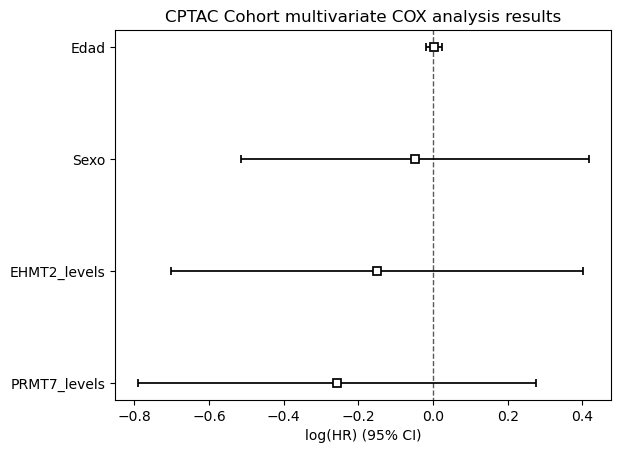

❌ Error en CPTAC: 'Estadío agrupado'

📊 Ejecutando modelo multivariante en: Compass
['EHMT2', 'PRMT7', 'Edad', 'Sexo', 'Estadío agrupado', 'Subtipo molecular']
The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 194 total observations, 51 right-censored observations>
         test_name = proportional_hazard_test

---
                   test_statistic    p  -log2(p)
EHMT2_levels km              5.73 0.02      5.91
             rank            6.20 0.01      6.29
Edad         km              3.00 0.08      3.59
             rank            3.44 0.06      3.97
PRMT7_levels km              2.24 0.13      2.89
             rank            2.33 0.13      2.98
Sexo         km              0.00 0.98      0.02
             rank            0.01 0.94      0.09



1. Variable 'EHMT2_levels' failed the non-proportional test: p-value is 0.0128.

   Advice: with so few unique values (only 2), you can include `strata=['EHMT2_levels', ...]` in the
call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



<lifelines.CoxPHFitter: fitted with 194 total observations, 51 right-censored observations>
             duration col = 'Tiempo'
                event col = 'Supervivencia'
      baseline estimation = breslow
   number of observations = 194
number of events observed = 143
   partial log-likelihood = -635.90
         time fit was run = 2025-07-07 10:46:47 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
Edad          0.00      1.00      0.01           -0.02            0.02                0.98                1.02
Sexo          0.04      1.04      0.17           -0.29            0.37                0.75                1.45
EHMT2_levels -0.20      0.82      0.20           -0.58            0.19                0.56                1.21
PRMT7_levels  0.22      1.25      0.20           -0.17            0.61                0.85                1.83

              cmp to     z    p  -log2(p)
covariate                                
Edad            0.00  0.30 0.76      0.39
Sexo            0.00  0.23 0.82      0.28
EHMT2_levels    0.00 -0.99 0.32      1.63
PRMT7_levels    0.00  1.11 0.27      1.90
---
Concordance = 0.56
Partial AIC = 1279.80
log-likelihood ratio test = 1.61 on 4 df
-log2(p) of ll-ratio test = 0.31



covariate
Edad            0.762569
Sexo            0.820982
EHMT2_levels    0.322914
PRMT7_levels    0.267406
Name: p, dtype: float64


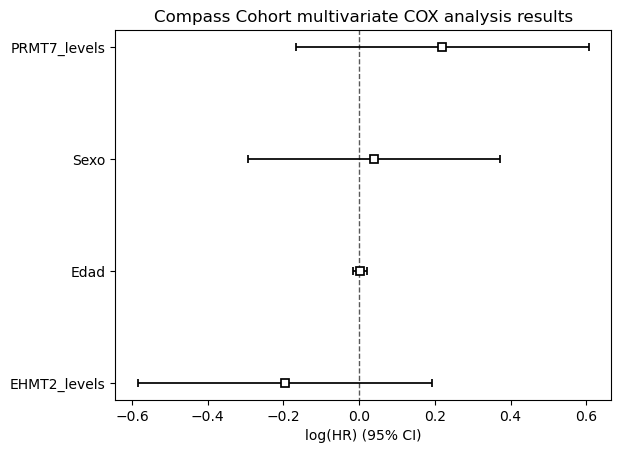

❌ Error en Compass: 'Estadío agrupado'


In [31]:
# Análisis Cox Multivariante con variables clínicas y genes de interés
genes_interes = ['EHMT2', 'PRMT7']
covariables_clinicas = ['Edad', 'Sexo', 'Estadío agrupado', 'Subtipo molecular']
tiempo = 'Tiempo'
evento = 'Supervivencia'

resultados_multi = {}

for cohort_name, df in reformatted['Full data'].items():
    print(f'\n📊 Ejecutando modelo multivariante en: {cohort_name}')
    try:
        resultado = AnalisisMultiCox(
            Cohort=df,
            Genes=genes_interes,
            Features=covariables_clinicas,
            Time=tiempo,
            Survival=evento,
            Key=cohort_name,
            Mode='Multi'
        )
        resultados_multi[cohort_name] = resultado
        print(resultado[['HR', 'p-value', 'Coef_low', 'Coef_high']])
    except Exception as e:
        print(f'❌ Error en {cohort_name}: {e}')

In [14]:
# Cargar la cohorte completa (si no la tienes en memoria)
df_compass = pd.read_feather("Cohortes/Combat_Data/COMBAT_with6datasets/Combat6_Final_Compass_Log2TPMplus1.feather")

# Definir genes y covariables clínicas
genes_interes = ['EHMT2', 'PRMT7']
covariables = ['Edad', 'Sexo', 'Estadio agrupado']

# Ejecutar análisis para cada tratamiento
resultados_GA  = CompassPorTratamiento(df_compass, 'GA', genes_interes, covariables)
resultados_FFX = CompassPorTratamiento(df_compass, 'FFX', genes_interes, covariables)

FileNotFoundError: [Errno 2] No such file or directory: 'Cohortes/Combat_Data/COMBAT_with6datasets/Combat6_Final_Compass_Log2TPMplus1.feather'